# Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса. Ниже расскажем о деталях этого процесса. Их важно знать, прежде чем генерировать новые признаки.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).  

# Описание данных


Данные состоят из нескольких файлов, полученных из разных источников:

   + __data_arc_new.csv — данные об электродах__
        + key — номер партии
        + Начало нагрева дугой — время начала нагрева
        + Конец нагрева дугой — время окончания нагрева
        + Активная мощность — значение активной мощности
        + Реактивная мощность — значение реактивной мощности
   + __data_bulk_new.csv — данные о подаче сыпучих материалов (объём)__
       + key — номер партии
       + Bulk 1 … Bulk 15 — объём подаваемого материала
   + __data_bulk_time_new.csv — данные о подаче сыпучих материалов (время)__
       + key — номер партии
       + Bulk 1 … Bulk 15 — время подачи материала
   + __data_gas_new.csv — данные о продувке сплава газом__
       + key — номер партии
       + Газ 1 — объём подаваемого газа
   + __data_temp_new.csv — результаты измерения температуры__
       + key — номер партии
       + Время замера — время замера
       + Температура — значение температуры
   + __data_wire_new.csv — данные о проволочных материалах (объём)__
       + key — номер партии
       + Wire 1 … Wire 15 — объём подаваемых проволочных материалов
   + __data_wire_time_new.csv — данные о проволочных материалах (время)__
       + key — номер партии
       + Wire 1 … Wire 15 — время подачи проволочных материалов

## Загрузка данных

<font color='9933ff'><b>
Подключение библиотек
</b></font>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.dummy import DummyRegressor

<font color='9933ff'><b>
Загрузка данных
</b></font>

In [2]:
df1= pd.read_csv('')
df2= pd.read_csv('')
df3= pd.read_csv('')
df4= pd.read_csv('')
df5= pd.read_csv('')
df6= pd.read_csv('')
df7= pd.read_csv('')

<font color='9933ff'><b>
Описание функции для первичного осмотра данных
</b></font>

In [3]:
def show_info(df, features = None):
    display(df.info())
    display(df.describe())
    display(df.head(3))
    display(df.tail(3))
    if features is None:
        return
    else:
        for feature in features:
            plt.style.use('seaborn-v0_8-darkgrid')
            plt.figure(figsize=(14,7))
            sns.histplot(df[feature], alpha=0.7, color='darkorchid', bins = 150)
            plt.title(f"Параметр: {feature}")
            plt.xlabel("Значения")
            plt.ylabel("Количество")
            plt.show()

<font color='9933ff'><b>
Осмотрим данные об электродах, преобразуем тип данных к дате и переименуем колонки.
    Для корректной визуализации отбросим одну запись с отрицательной температурой реактивной мощности
</b></font>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               14876 non-null  int64  
 1   start_heating_tm  14876 non-null  object 
 2   end_heating_tm    14876 non-null  object 
 3   active_p          14876 non-null  float64
 4   reactive_p        14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,active_p,reactive_p
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


,key,start_heating_tm,end_heating_tm,active_p,reactive_p
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460


,key,start_heating_tm,end_heating_tm,active_p,reactive_p
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347


<class 'pandas.core.frame.DataFrame'>
Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               14875 non-null  int64  
 1   start_heating_tm  14875 non-null  object 
 2   end_heating_tm    14875 non-null  object 
 3   active_p          14875 non-null  float64
 4   reactive_p        14875 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 697.3+ KB


None

,key,active_p,reactive_p
count,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.662749,0.487115
std,934.593897,0.258894,0.197612
min,1.000000,0.223120,0.153777
25%,806.000000,0.467115,0.337190
50%,1617.000000,0.599578,0.441665
75%,2429.000000,0.830135,0.608223
max,3241.000000,1.463773,1.270284


,key,start_heating_tm,end_heating_tm,active_p,reactive_p
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460


,key,start_heating_tm,end_heating_tm,active_p,reactive_p
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347


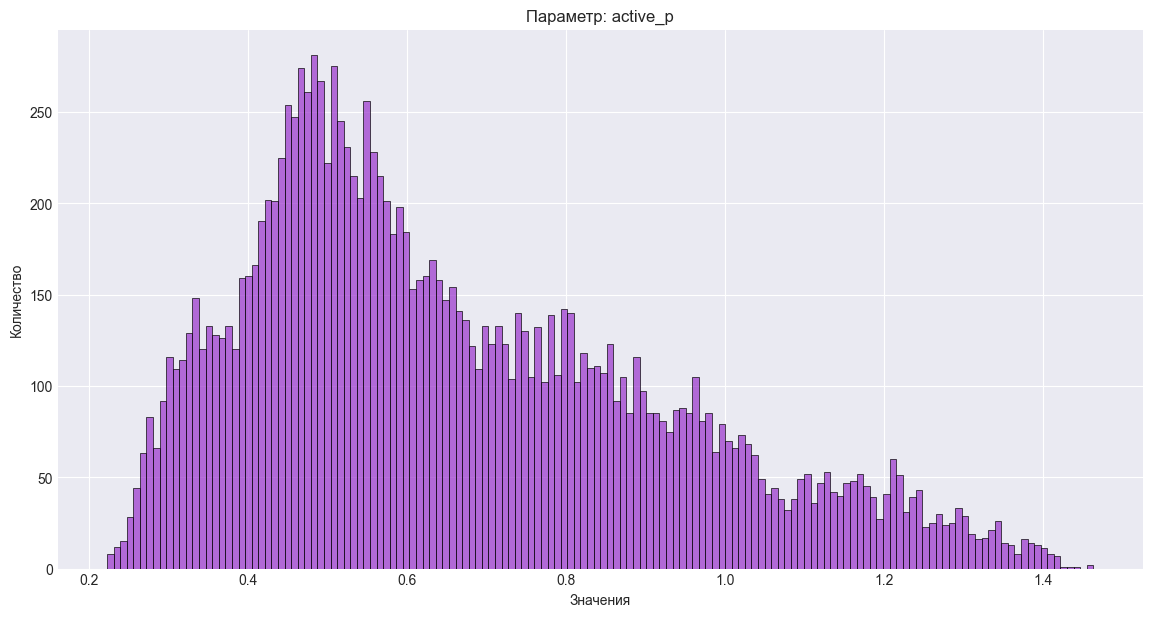

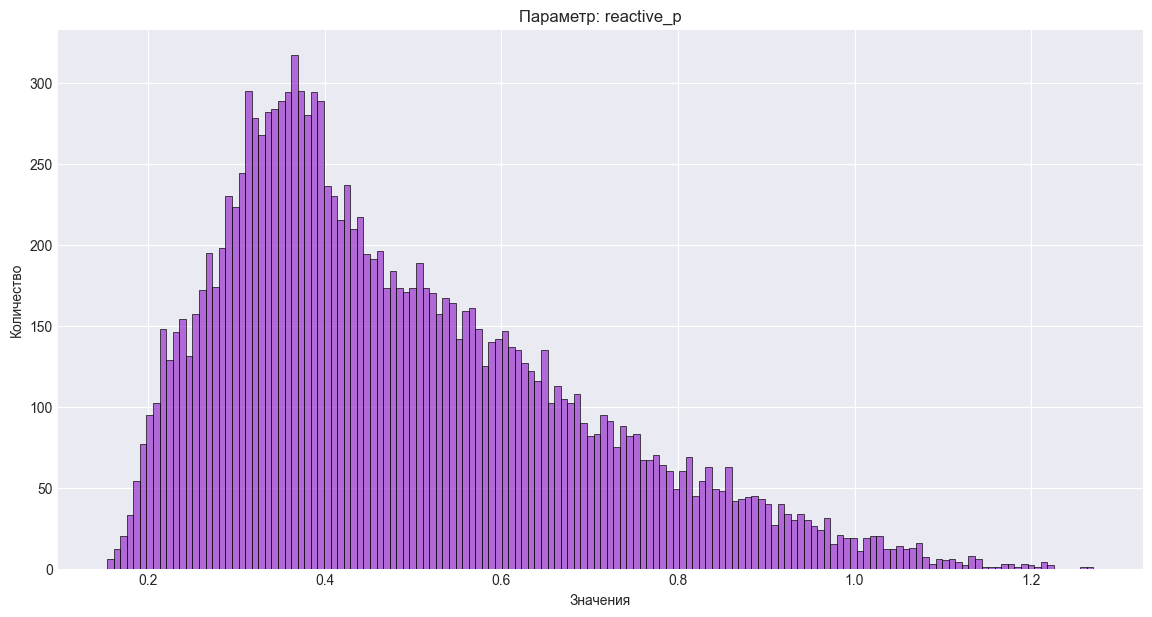

In [4]:
df1.columns = ['key', 'start_heating_tm', 'end_heating_tm', 'active_p', 'reactive_p']
df1.iloc[:, 1:3] = df1.iloc[:, 1:3].apply(pd.to_datetime)
show_info(df1)
show_info(df1.loc[df1.iloc[:, 4] > 0], df1.columns[3:5])

> Всего есть 14876 наблюдений(одно наблюдение c аномально отрицательным значением реактивной тяги) за 3241 партию. Наблюдения велись с 3 мая 2019 года до 6 сентября 2019 года то есть 4 полных месяца. В активной и реактивной мощности присутствует разрыв между 75% квантилем и максимальным значением. Возможно к некоторым партиям приходится использовать высокую мощность для нагрева сырья.

<font color='9933ff'><b>
Осмотрим данные о подаче сыпучих материалов и визуализируем все колонки кроме номера партии
    </b></font>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


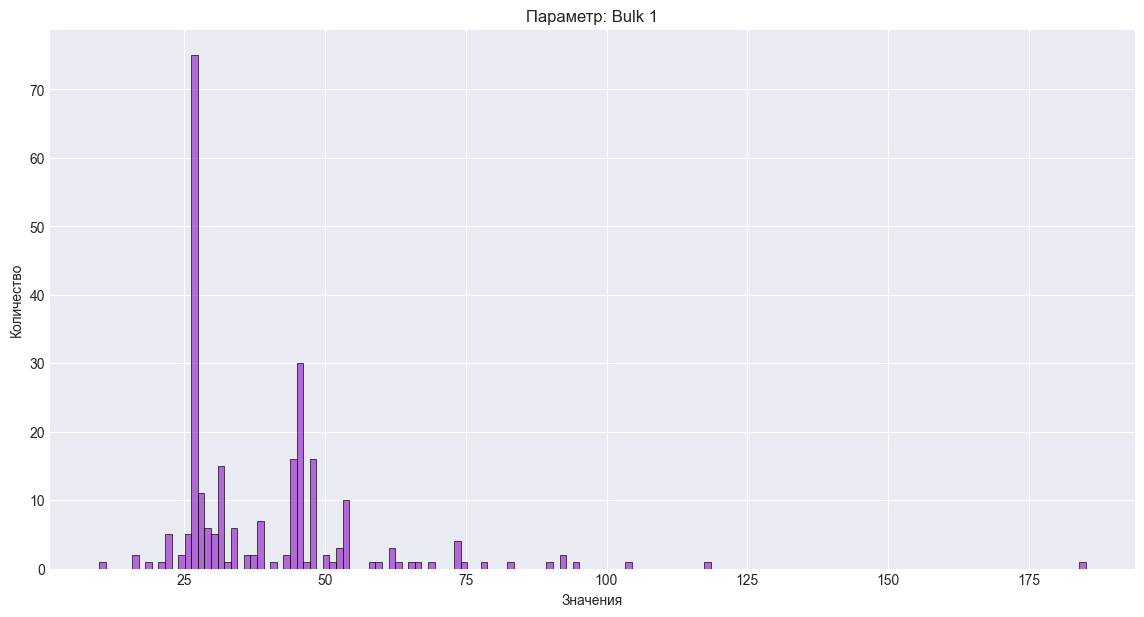

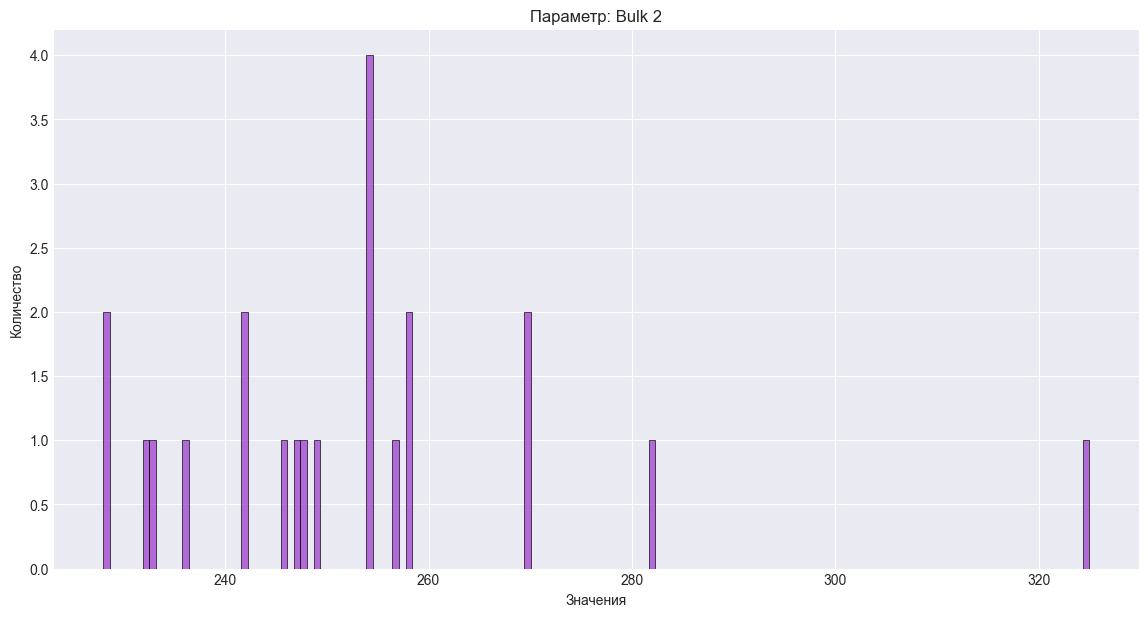

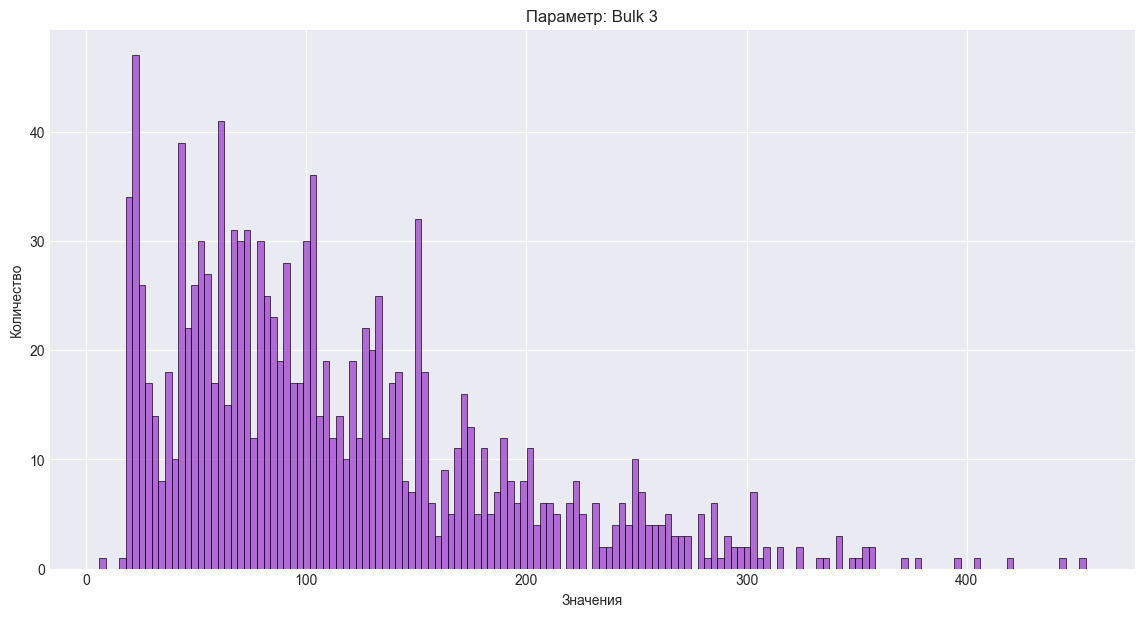

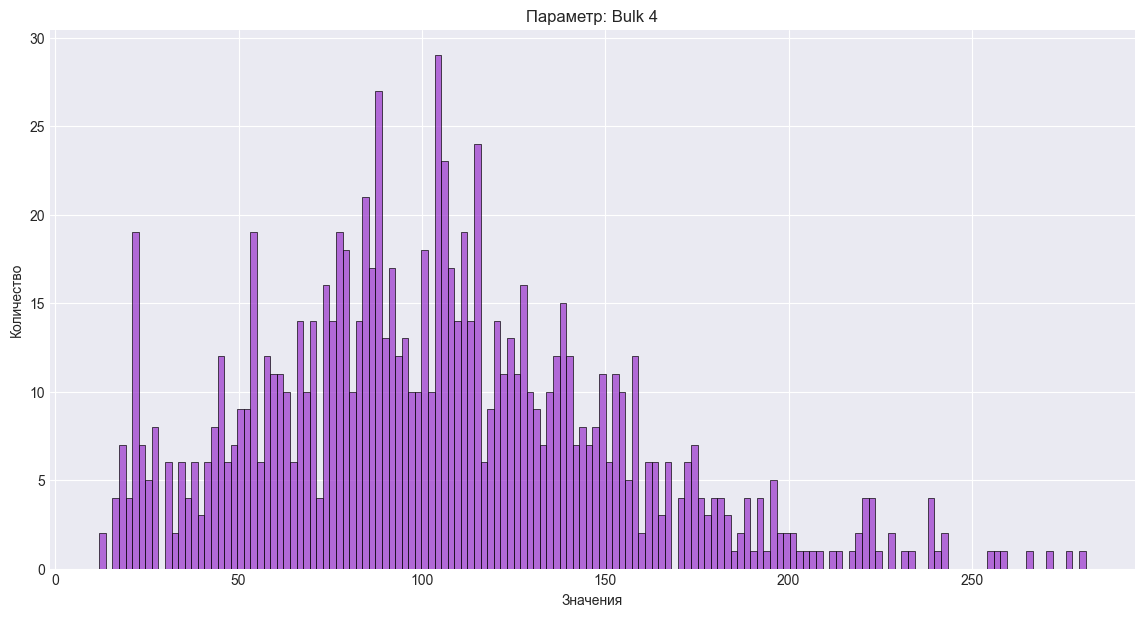

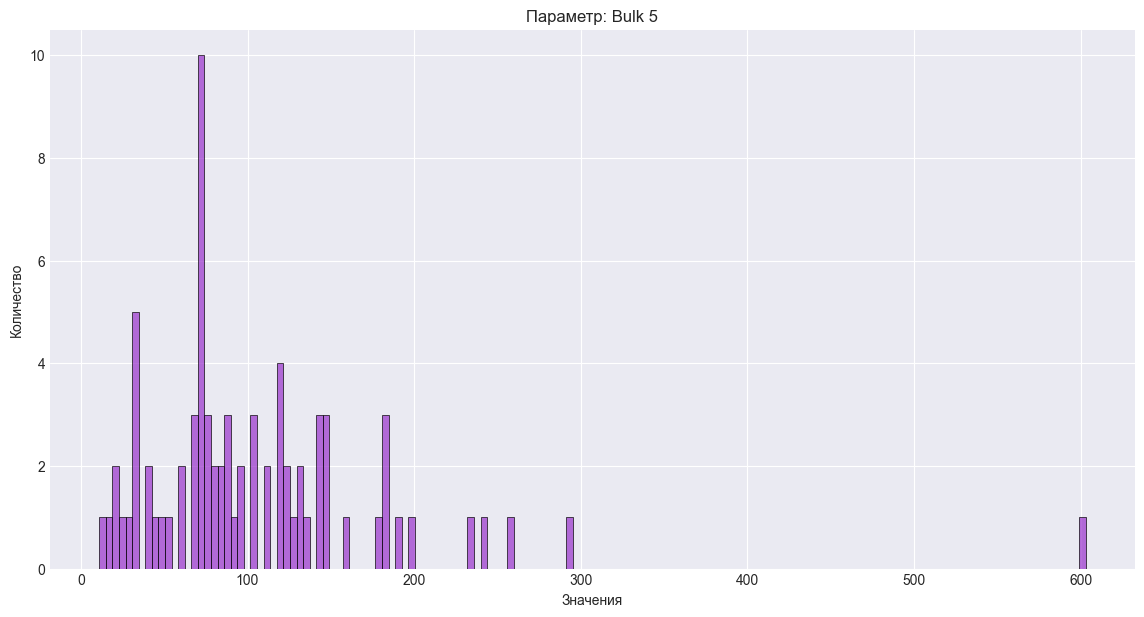

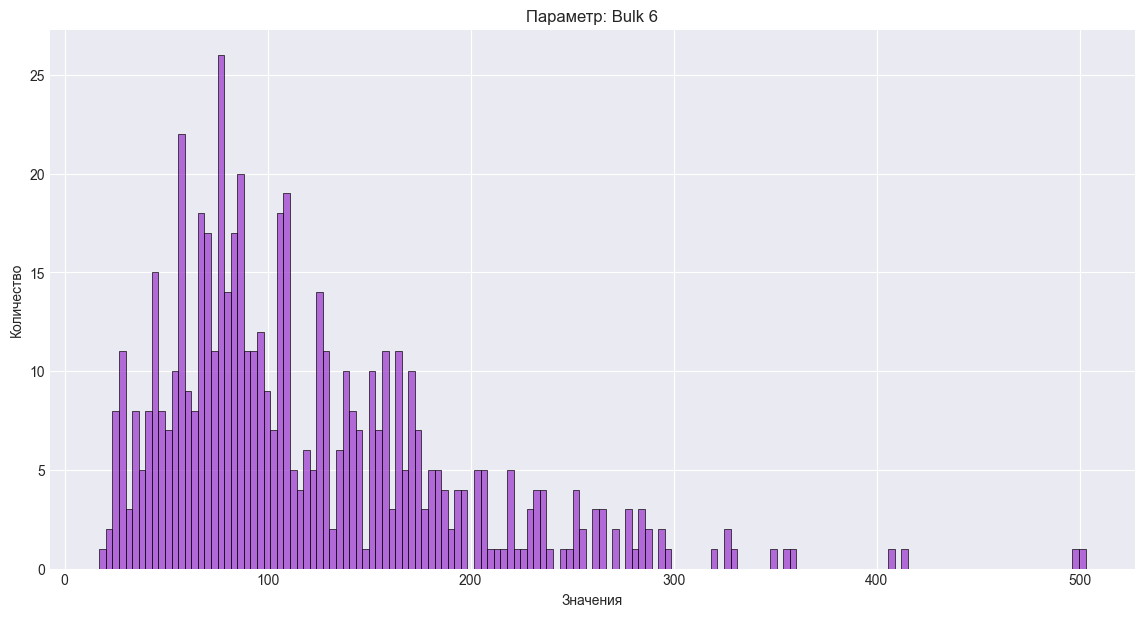

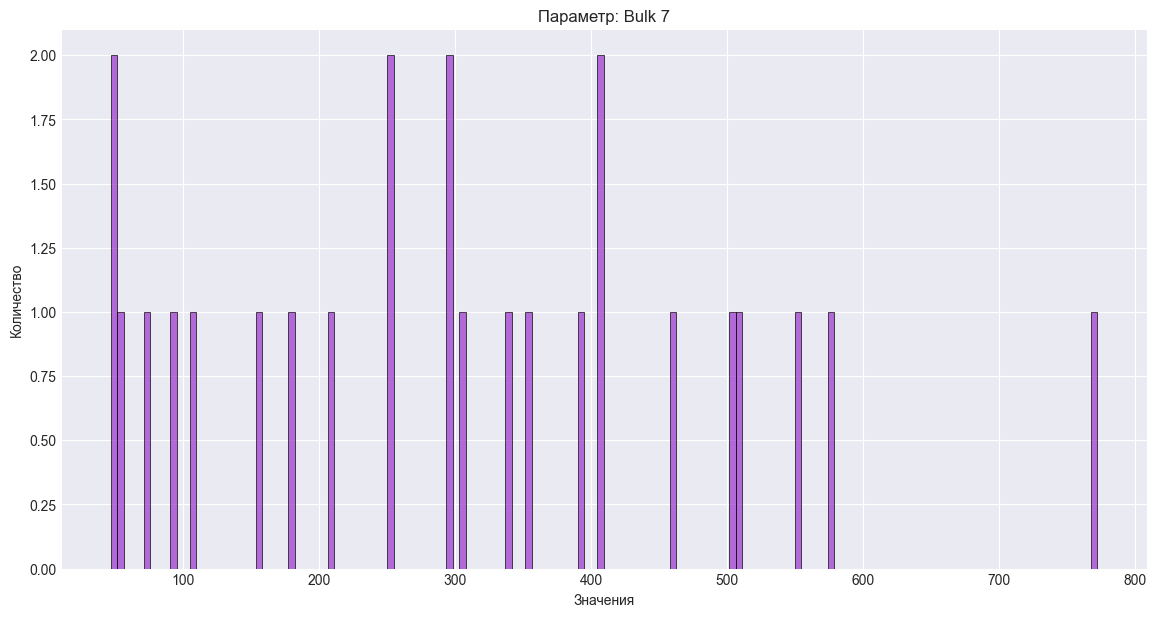

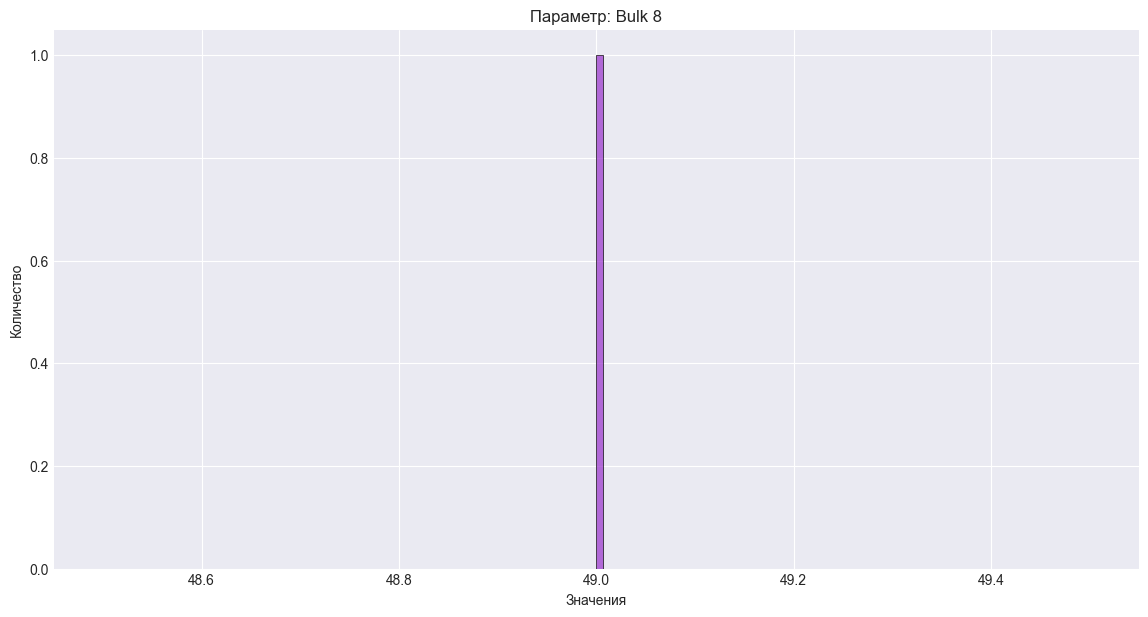

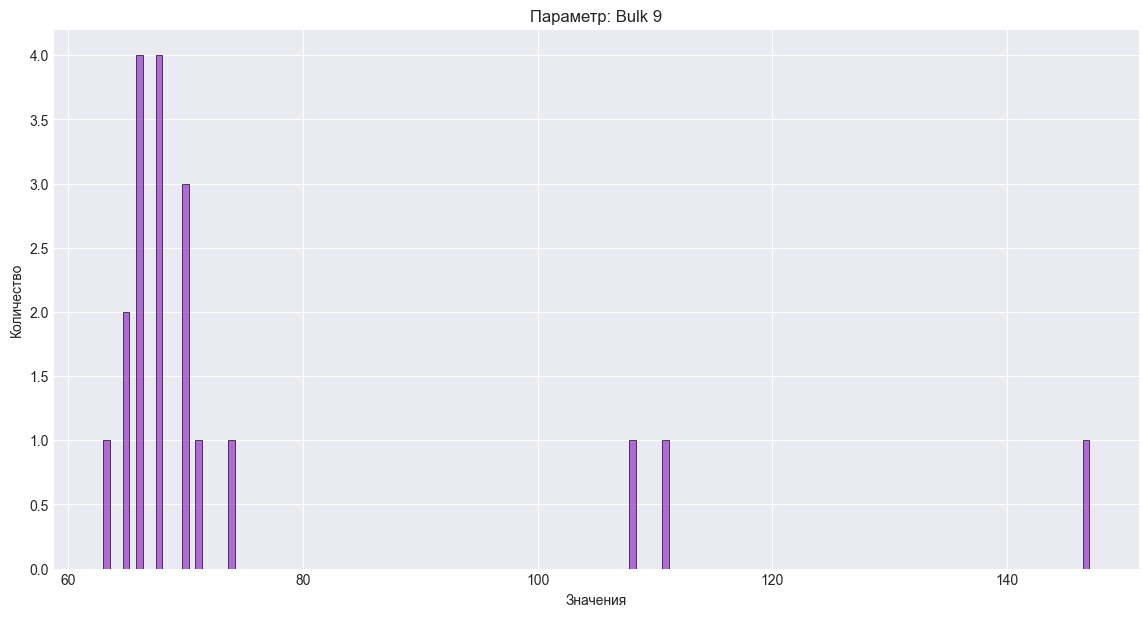

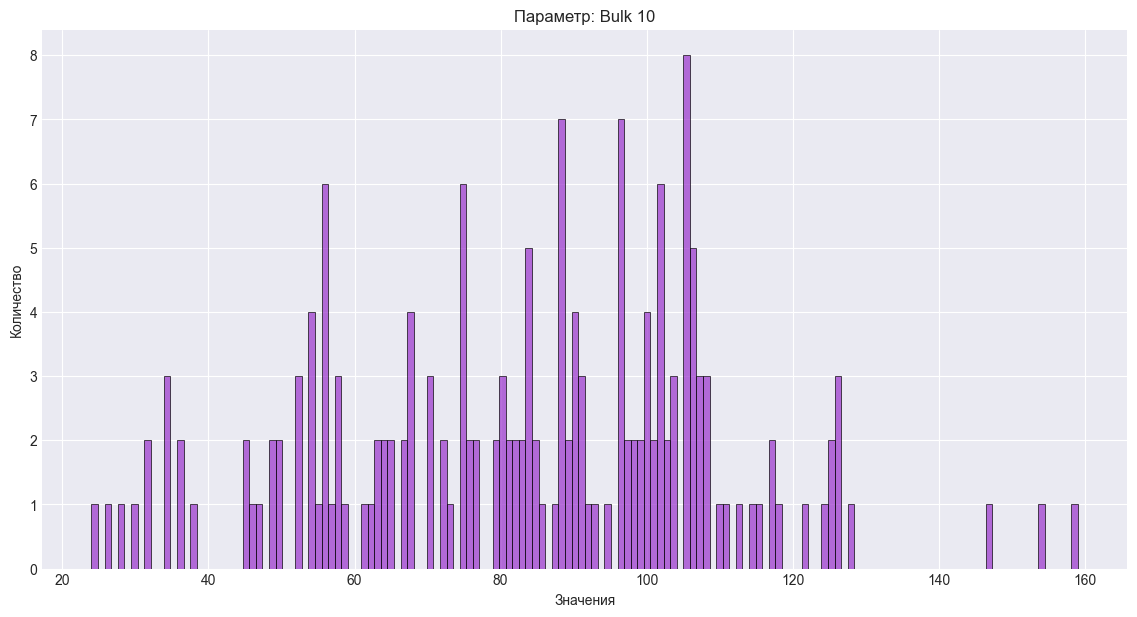

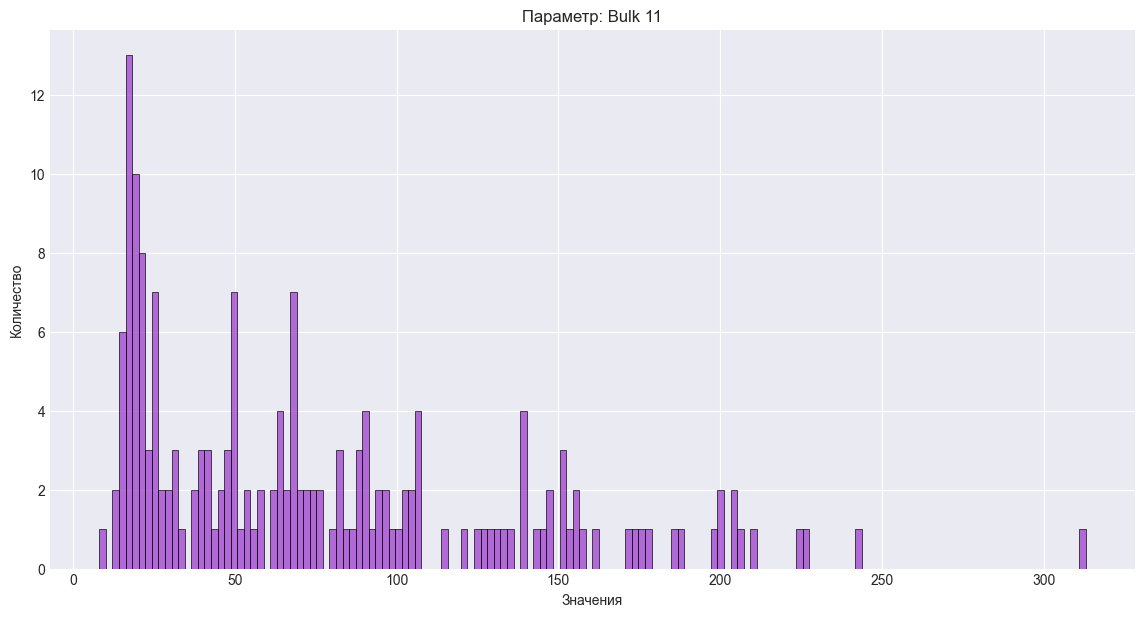

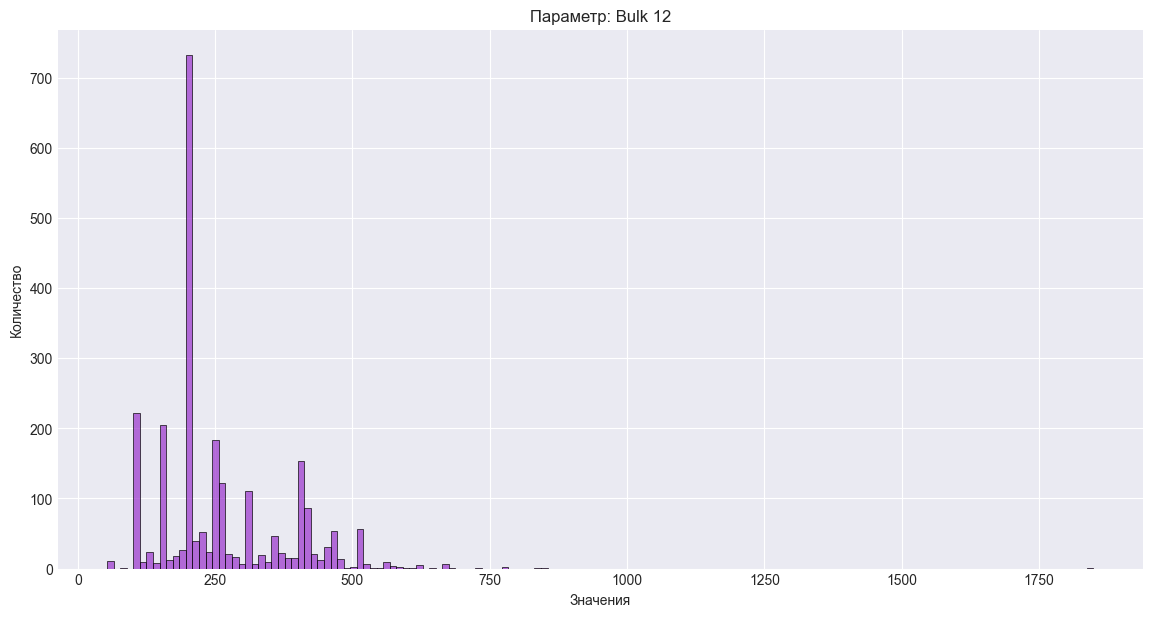

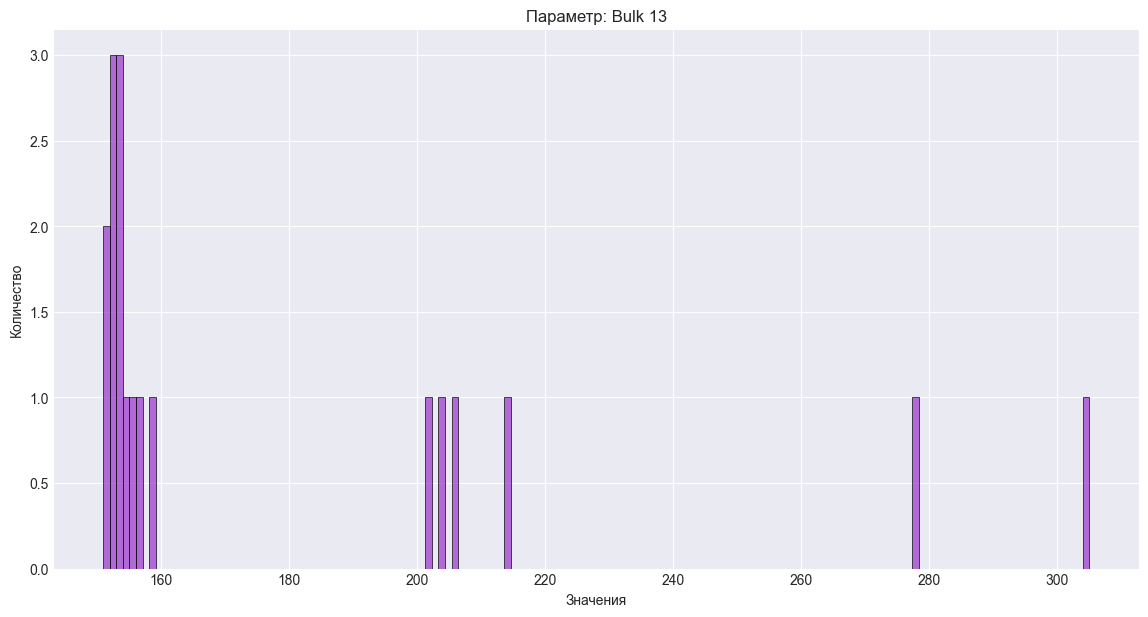

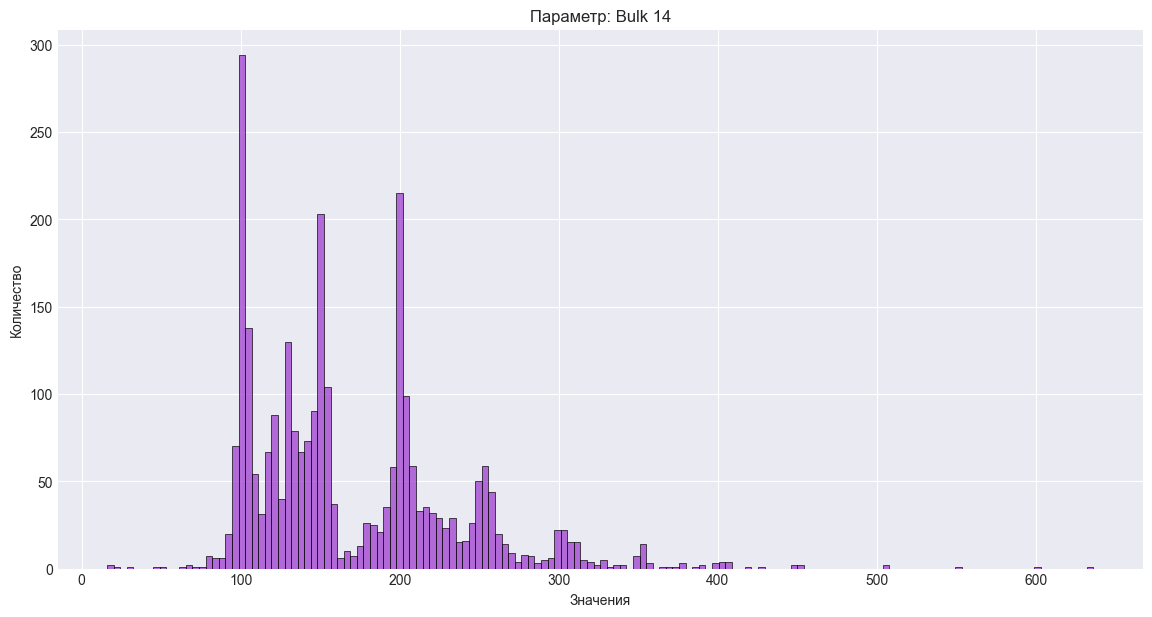

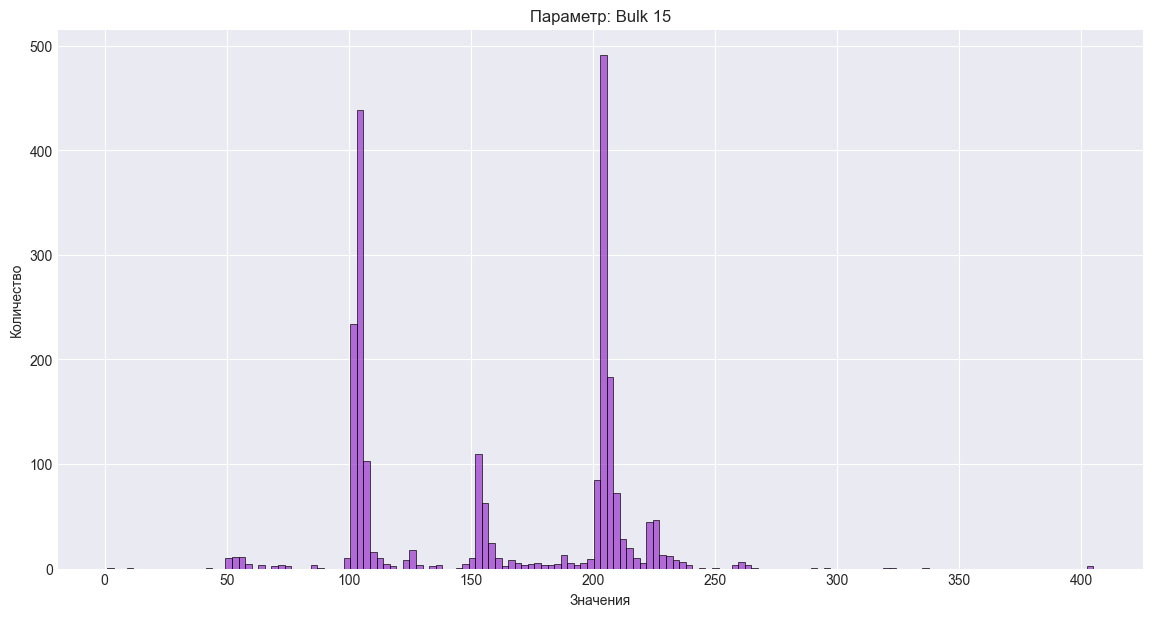

In [5]:
show_info(df2, df2.columns[1:])

> Количество записей о подаче сыпучих материалов 3129, что меньше количества партий, то есть не во все партии добавляются материалы. Некоторы материалы добавляются реже остальных. Например материал номер 8(Bulk 8) за все наблюдения был использован всего один раз.

<font color='9933ff'><b>
Осмотрим данные о подаче сыпучих материалов (время) и преобразуем тип данных
</b></font>

In [6]:
df3.iloc[:, 1:16] = df3.iloc[:, 1:16].apply(pd.to_datetime)
show_info(df3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3126,3239,NaT,NaT,NaT,NaT,NaT,2019-09-06 15:06:00,NaT,NaT,NaT,NaT,NaT,2019-09-06 15:01:44,NaT,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaT,NaT,NaT,NaT,NaT,2019-09-06 16:24:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 16:07:29,2019-09-06 16:01:34
3128,3241,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 17:26:33,2019-09-06 17:23:15


<font color='9933ff'><b>
Осмотрим данные  данные о продувке сплава газом и переименуем колонки
</b></font>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gaz     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,gaz
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


,key,gaz
0,1,29.749986
1,2,12.555561
2,3,28.554793


,key,gaz
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


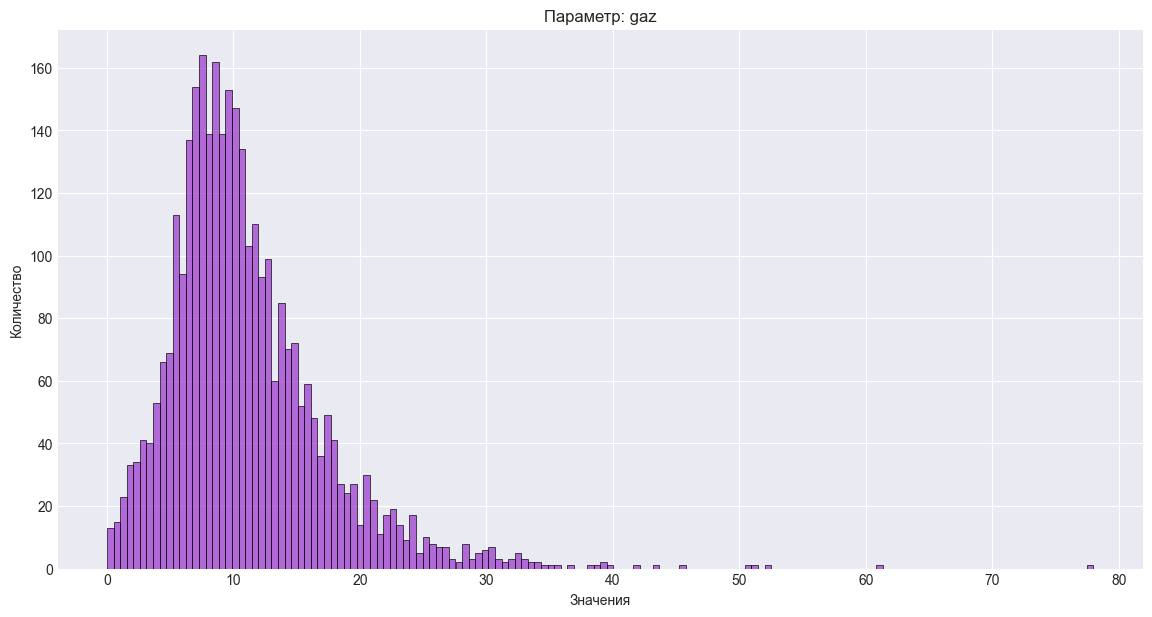

In [7]:
df4.columns = ['key', 'gaz']
show_info(df4, df4.columns[1:])

<font color='9933ff'><b>
Опишем функции для просмотра номеров партий, которых не хватает записей
</b></font>

In [8]:
def call_numbs(data):
    all_numbers = list(range(1, 3242))
    unique_values = data['key'].unique()
    missing_numbers = [number for number in all_numbers if number not in unique_values]
    print("Отсутствуют следующие партии в колонке:", missing_numbers)
    del all_numbers, unique_values, missing_numbers

In [9]:
call_numbs(df4)

Отсутствуют следующие партии в колонке: [193, 259]


> В двух партиях(193 и 259) газ не был подан, а также, как и в первом датафрейме большой разрыв между 75% квантилем и максимальным 

<font color='9933ff'><b>
Осмотрим результаты измерения температуры и преобразуем тип данных к дате и посмотрим на распределение температур
</b></font>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          18092 non-null  int64  
 1   time_by_t    18092 non-null  object 
 2   temperature  14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

,key,temperature
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


,key,time_by_t,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0


,key,time_by_t,temperature
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN
18091,3241,2019-09-06 17:30:05,NaN


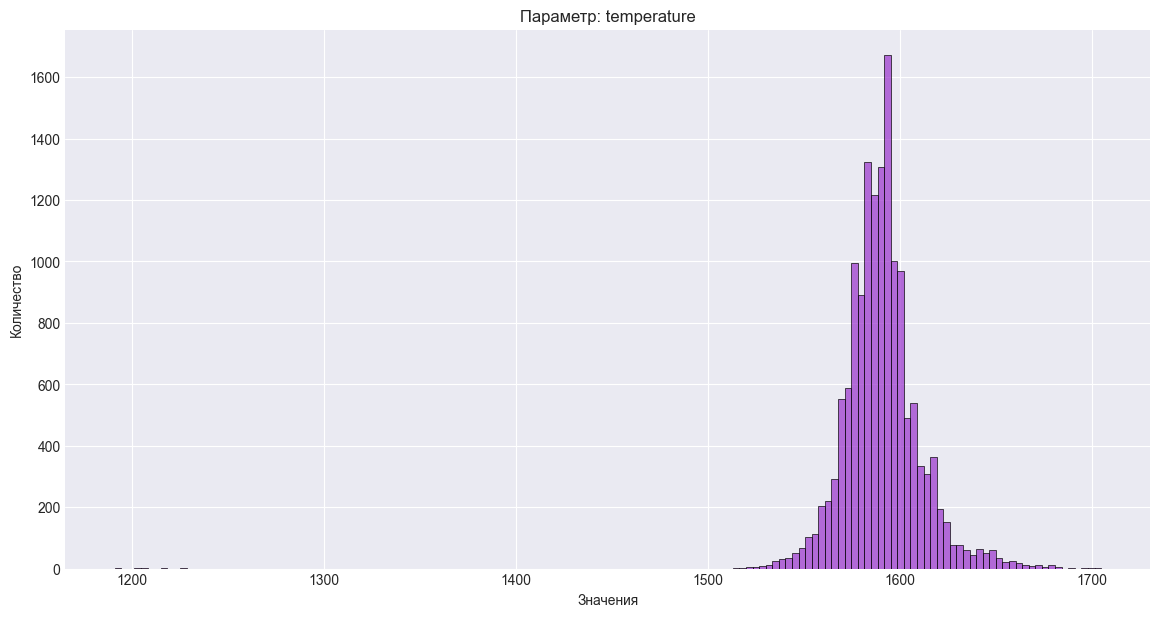

In [10]:
df5.columns = ['key', 'time_by_t', 'temperature']
df5.iloc[:, 1:2] = df5.iloc[:, 1:2].apply(pd.to_datetime)
show_info(df5, df5.columns[2:])

> За 3241 партию температуру измерили 18092 раза, измериния близки к 1600 градусам

<font color='9933ff'><b>
Осмотрим данные о проволочных материалах (объём)
</b></font>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


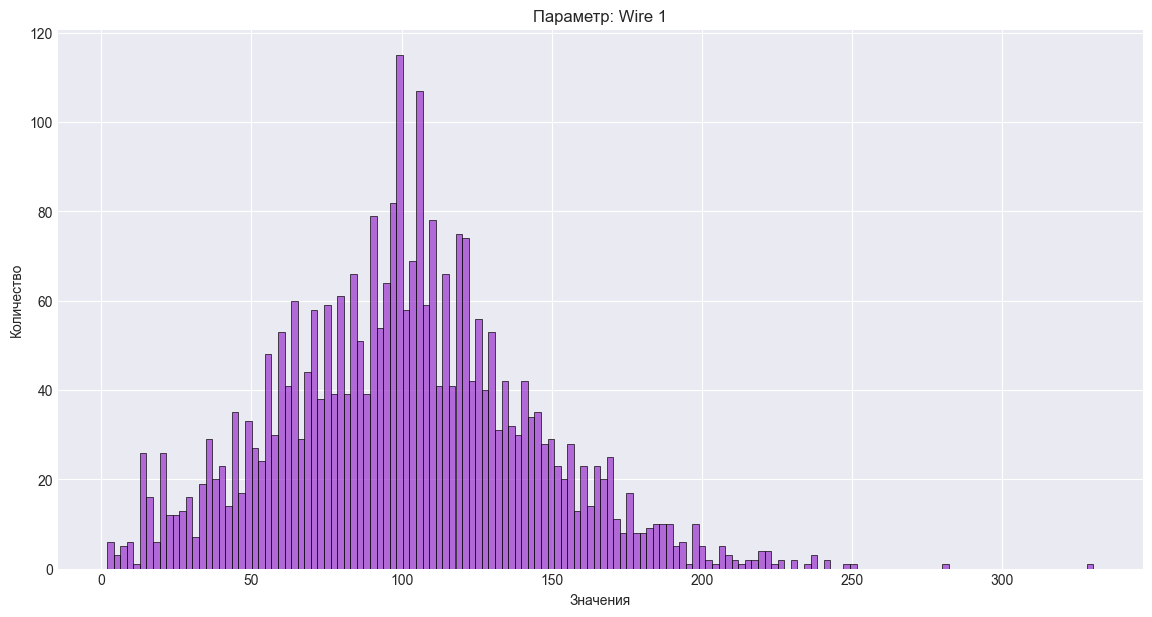

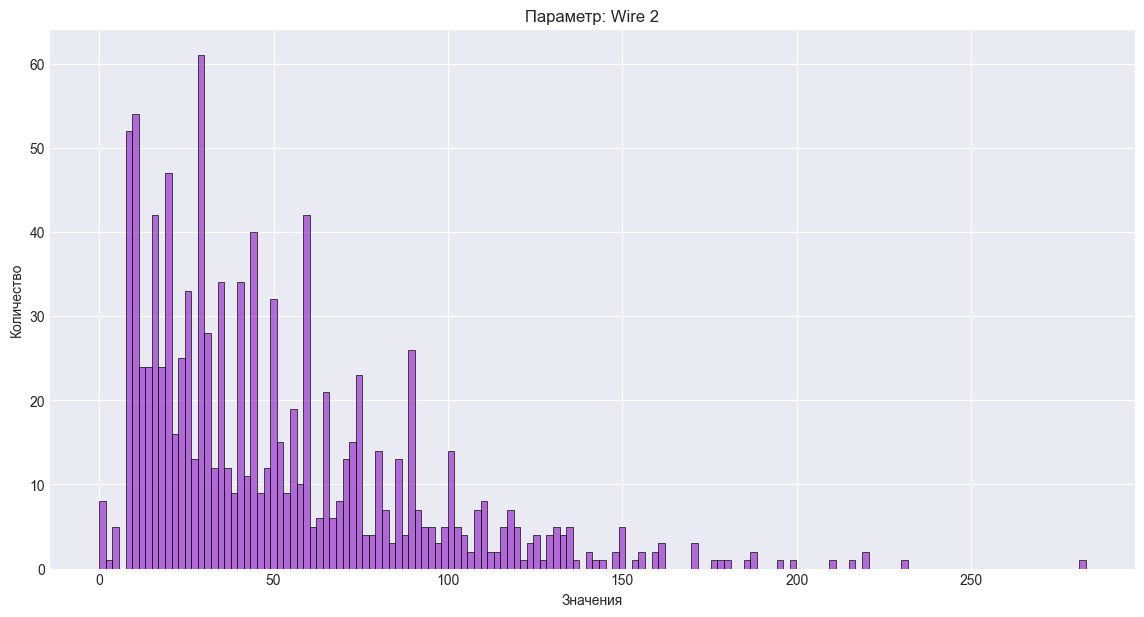

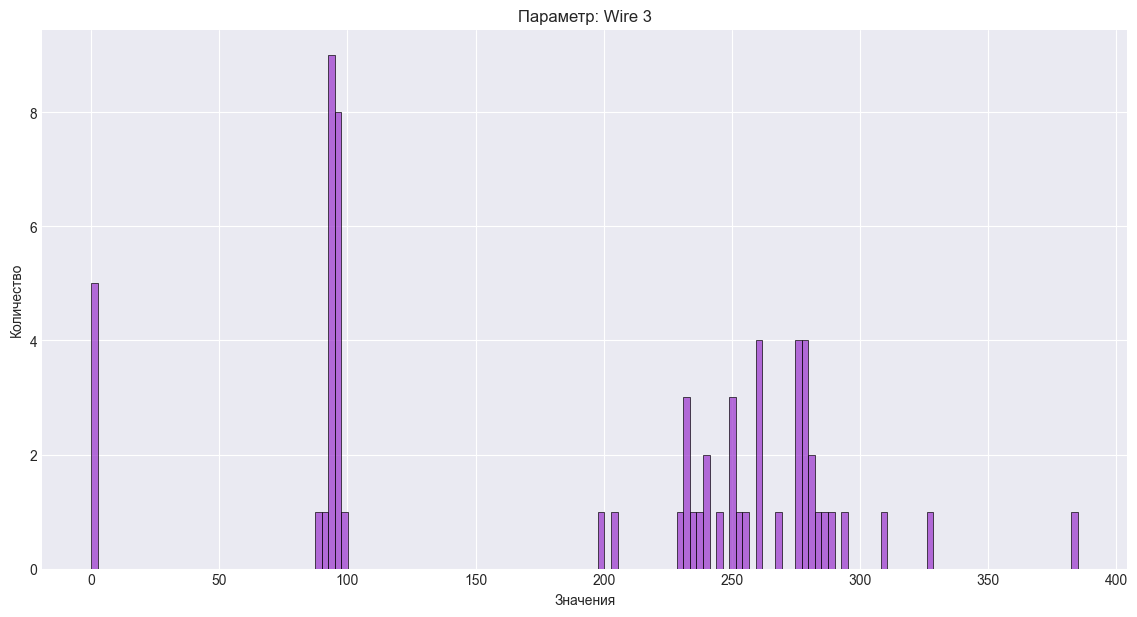

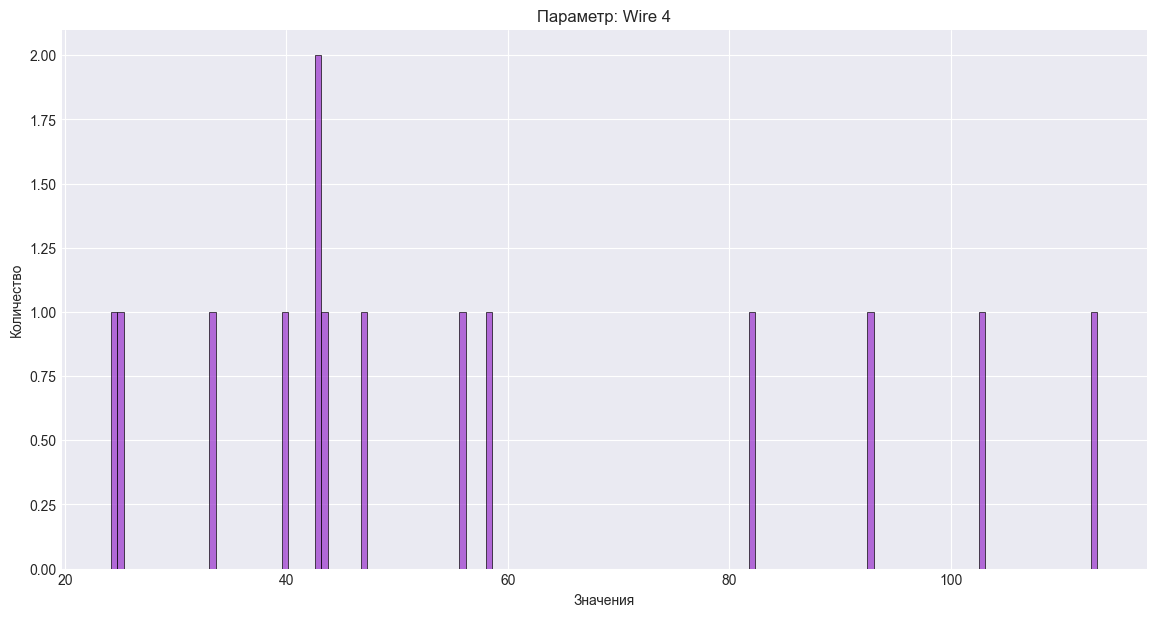

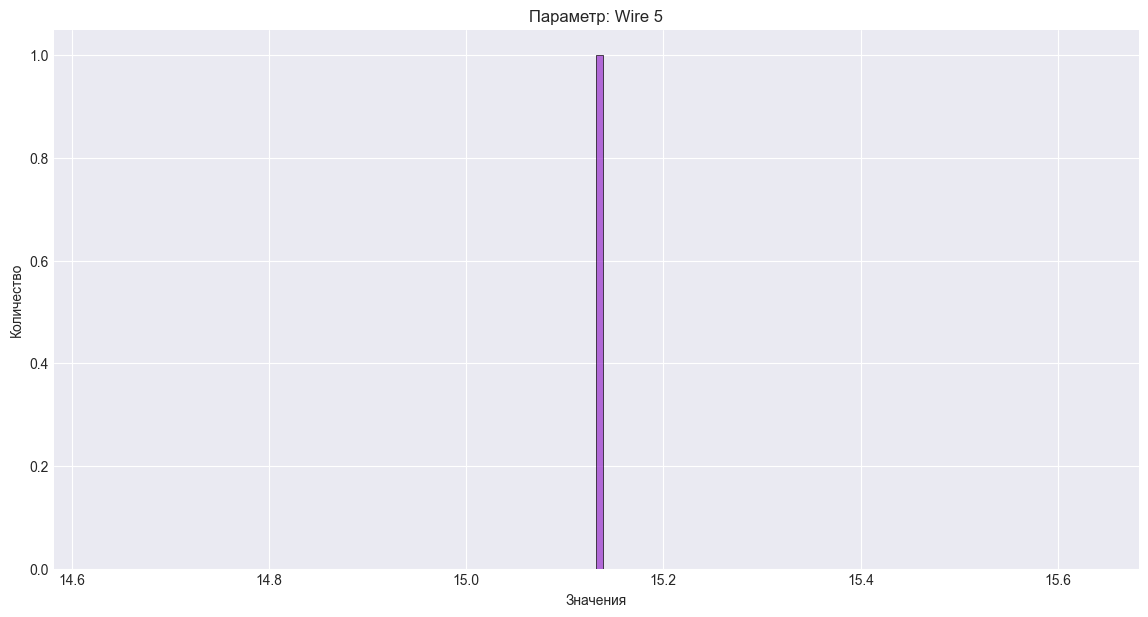

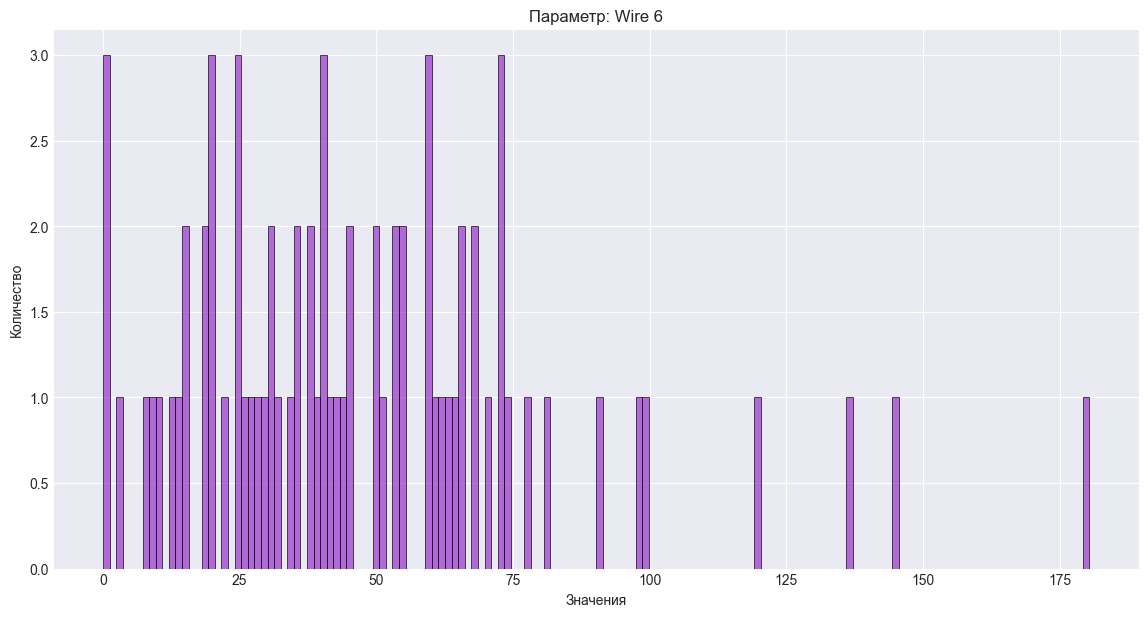

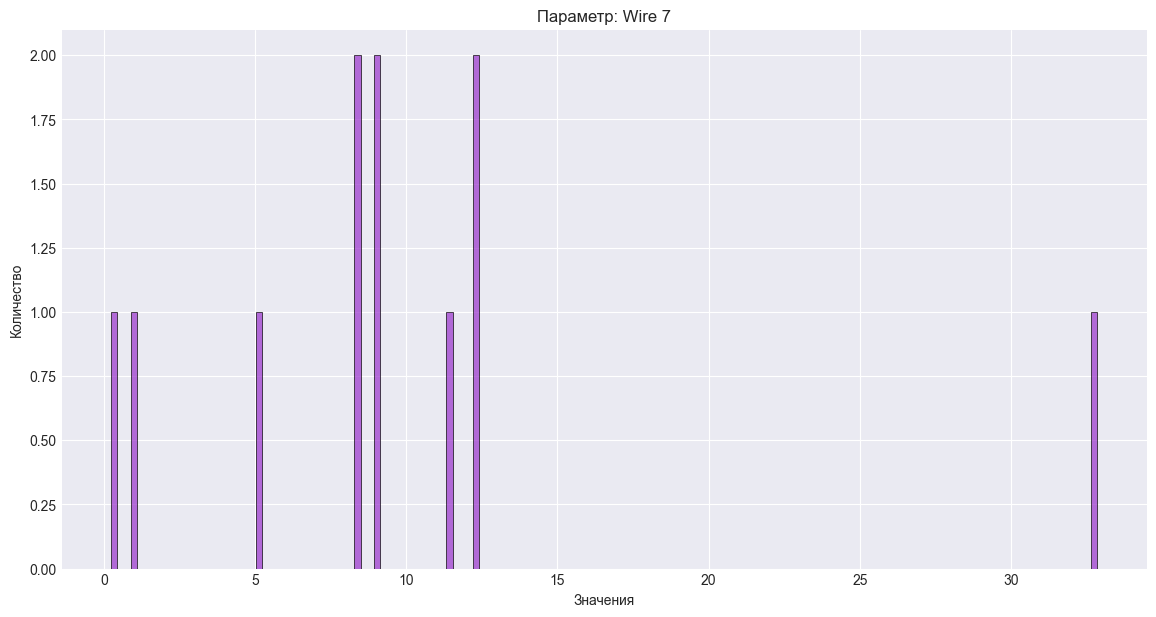

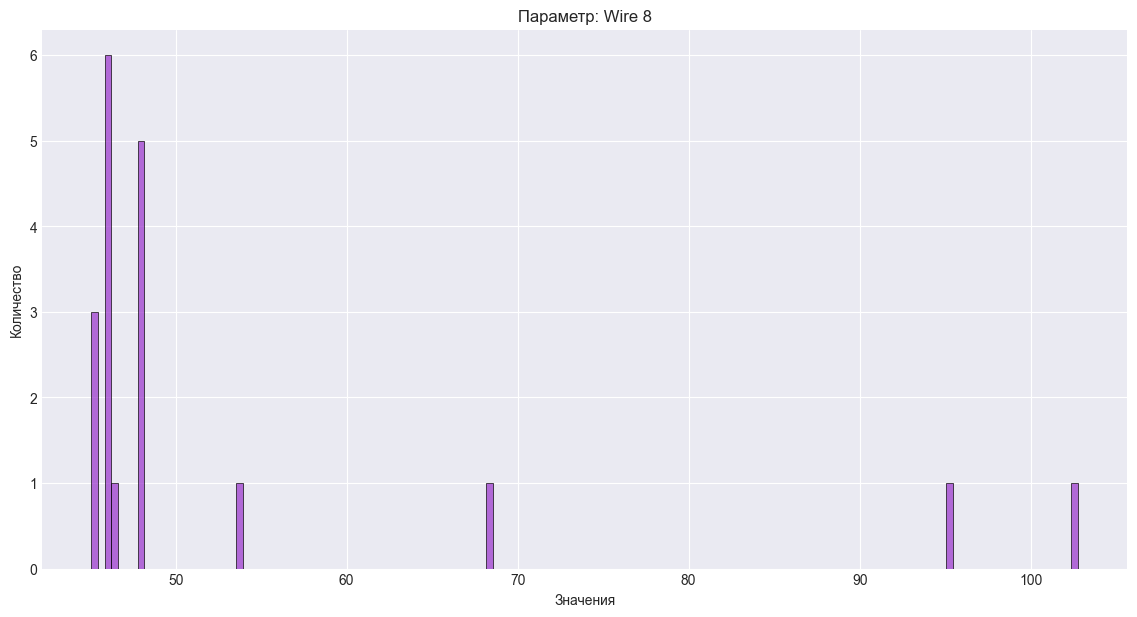

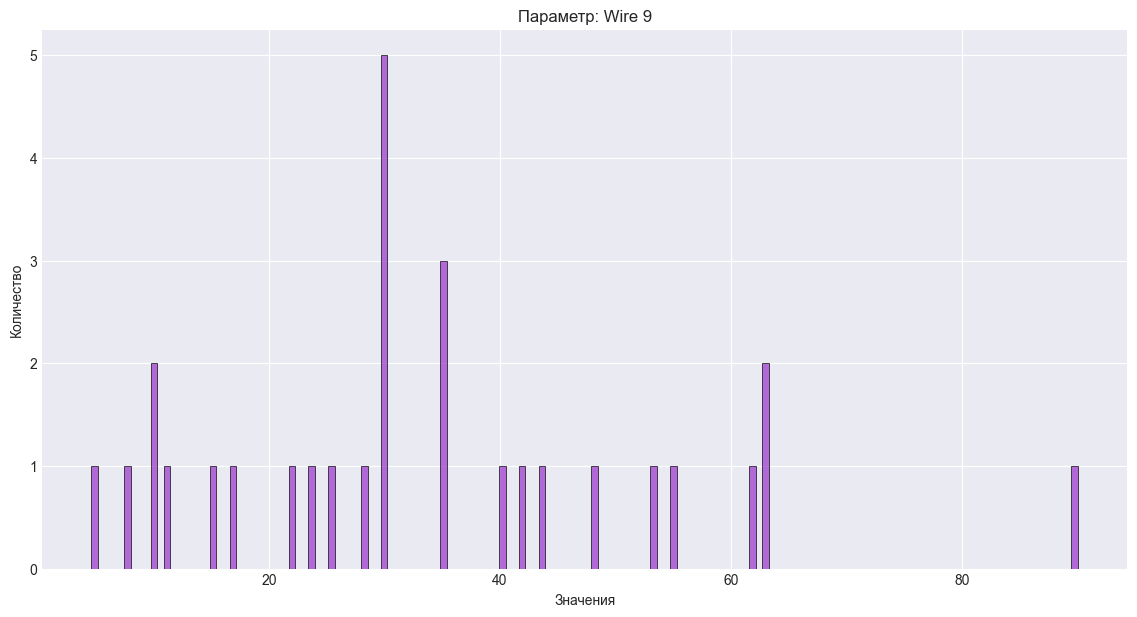

In [11]:
show_info(df6, df6.columns[1:])

> Количество записей о подаче проволочных материалов 3081, что меньше количества партий, то есть не во все партии добавляются материалы. Некоторы материалы добавляются реже остальных. Например материал номер 5(Wire 5) за все наблюдения был использован всего один раз.

<font color='9933ff'><b>
Осмотрим данные о проволочных материалах (время)
</b></font>

In [12]:
df7.iloc[:, 1:10] = df7.iloc[:, 1:10].apply(pd.to_datetime)
show_info(df7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3078,3239,2019-09-06 14:36:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3079,3240,2019-09-06 15:33:55,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3080,3241,2019-09-06 17:10:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


## Исследовательский анализ и предварительная обработка

### Данные об электродах

<font color='9933ff'><b>
Посмотрим на корреляцию между признаками. Напомню о наличии одного аномального наблюдения у реактивной мощности, во втором выводе отображена корреляция без учета этого наблюдения
</b></font>

display(df1.iloc[:, 1:].corr())
df1.loc[df1['reactive_p'] >= 0].iloc[:, 1:].corr()

> В первом выводе аномалия мешает сделать правильный вывод. По второму выводу можно сказать, что корреляция в 0,96 между активной и реактивной мощностями свидетельствует о том, что существует очень сильная положительная линейная взаимосвязь между этими признаками.

Посчитаем коэффициент мощности по формуле, где $P$ - активная мощность, $Q$ - реактивная мощность, $S$ - полная мощность и $cos(φ)$ - фактор мощности:
$$
S = √(P^2 + Q^2)
$$

$$
cos(φ) = P / S
$$

Результат этого деления дает представление об эффективности использования энергии в системе.

<font color='9933ff'><b>
Для каждой партии посчитаем средний коэффициент в соответствии формулам, указанным выше, тем самым сгенерируем новый признак. А для партии 2116 где реактивная мощность была равна -755 домножим значение на -1 так, как если Q будет отрицательным, это может значить, что нагрузка имеет емкостной характер, то есть энергия накапливается в нагрузке, а потом отдается обратно в сеть, что в свою очередь может привести к возможным проблемам с качеством энергии и нарушением работы оборудования. Однако отрицательное значение реактивной мощности может появиться, если в системе применяется компенсация реактивной мощности с целью устранения негативного влияния нагрузки на систему с помощью специальных устройств.
    </b></font>

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               14876 non-null  int64  
 1   start_heating_tm  14876 non-null  object 
 2   end_heating_tm    14876 non-null  object 
 3   active_p          14876 non-null  float64
 4   reactive_p        14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [14]:
df1.drop(9780, inplace=True)
df1['power_ratio'] = df1['active_p']/(np.sqrt(df1['active_p']**2 + df1['reactive_p']**2))
df1['time_of_heating'] = df1.end_heating_tm-df1.start_heating_tm
df1['time_of_heating'] = pd.to_timedelta(df1['time_of_heating'])
df1['time_in_seconds'] = df1['time_of_heating'].dt.total_seconds()


<font color='9933ff'><b>
Сгруппируем данные по партии, оставим начало первого нагрева, конец последнего нагрева и средний коэффициент мощности
    </b></font>

In [15]:
df1 = df1.groupby('key').agg({'start_heating_tm':'first',\
                              'end_heating_tm':'last','active_p':'mean',\
                              'reactive_p':'mean', 'power_ratio':'sum',\
                              'time_of_heating':'sum'}).reset_index()

In [16]:
df1

,key,start_heating_tm,end_heating_tm,active_p,reactive_p,power_ratio,time_of_heating
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,0.607346,0.428564,4.083428,0 days 00:18:18
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,0.534852,0.363339,3.301105,0 days 00:13:31
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,0.812728,0.587491,4.048621,0 days 00:10:55
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.676622,0.514248,3.175691,0 days 00:12:21
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,0.563238,0.421998,3.187274,0 days 00:14:29
...,...,...,...,...,...,...,...
3209,3237,2019-09-06 11:31:25,2019-09-06 11:53:55,0.508374,0.405083,3.915487,0 days 00:15:09
3210,3238,2019-09-06 12:16:25,2019-09-06 12:31:35,0.458274,0.346034,2.391324,0 days 00:09:06
3211,3239,2019-09-06 14:17:00,2019-09-06 15:05:50,0.606001,0.442693,6.413809,0 days 00:20:16
3212,3240,2019-09-06 15:25:31,2019-09-06 16:24:15,0.663536,0.474710,4.071563,0 days 00:13:59


In [17]:
call_numbs(df1)

Отсутствуют следующие партии в колонке: [41, 42, 195, 279, 355, 382, 506, 529, 540, 607, 683, 710, 766, 1133, 1300, 1437, 2031, 2103, 2278, 2356, 2373, 2446, 2469, 2491, 2683, 3200, 3207]


### Данные о подаче сыпучих материалов (объём)

In [18]:
df2

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [19]:
df2.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [20]:
cols = ['Bulk 1', 'Bulk 2', 'Bulk 5', 'Bulk 6', 'Bulk 7' ,'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 13']
df2['rare_bulks'] = df2[cols].sum(axis=1)
df2 = df2.drop(cols, axis=1)
df2 = df2.fillna(0)

In [21]:
df2

,key,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,rare_bulks
0,1,0.0,43.0,206.0,150.0,154.0,0.0
1,2,0.0,73.0,206.0,149.0,154.0,0.0
2,3,0.0,34.0,205.0,152.0,153.0,0.0
3,4,0.0,81.0,207.0,153.0,154.0,0.0
4,5,0.0,78.0,203.0,151.0,152.0,0.0
...,...,...,...,...,...,...,...
3124,3237,170.0,0.0,252.0,130.0,206.0,0.0
3125,3238,126.0,0.0,254.0,108.0,106.0,0.0
3126,3239,0.0,0.0,158.0,270.0,88.0,114.0
3127,3240,0.0,0.0,0.0,192.0,54.0,26.0


>Редкие события проссумированы в одно поле. Пропуски заполнены нолями так, как объем добавления материалов равен 0 если его не добавляли. Сыпучие материалы под номерами 12, 14 и 15 используются в 70-80% случаев.

### Данные о продувке сплава газом

In [22]:
df4

,key,gaz
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


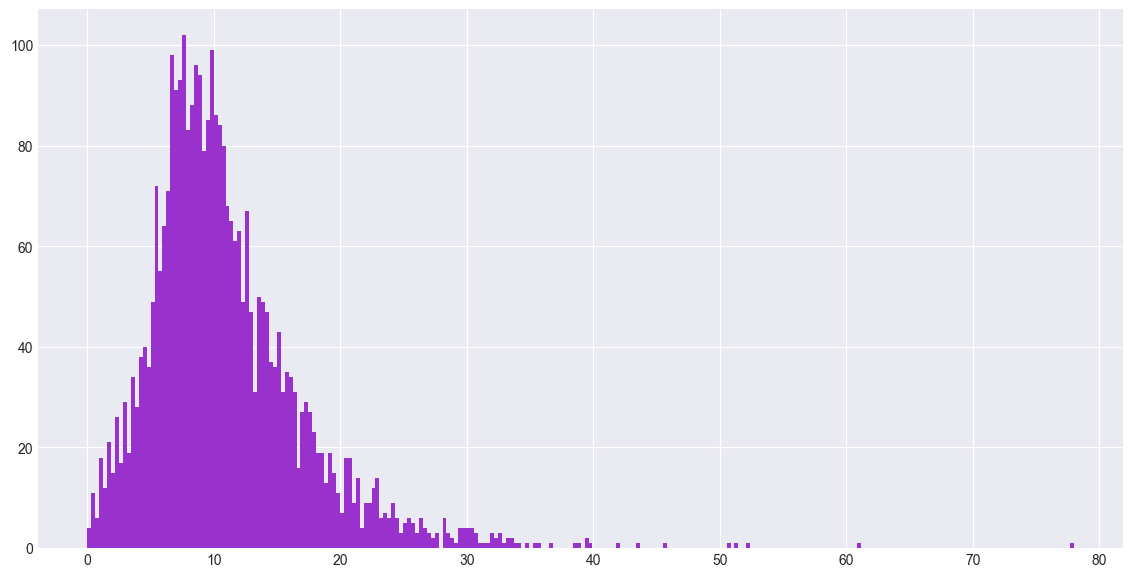

In [23]:
df4.gaz.hist(figsize=(14, 7), color='darkorchid', bins= 250)
plt.show()

> В основном диапазон объема подачи газа варьируется от 5 до 20, но бывают случаи, когда объем газа доходит до 77.

###  Результаты измерения температуры

In [24]:
df5

,key,time_by_t,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


<font color='9933ff'><b>
Задача спрогнозировать последнее измерение температуры каждой партии, поэтому количество таких замеров должно быть больше 1, сгруппируем записи по ключу и отфильтруем по количеству измерений.
    </b></font>

In [25]:
df5 = df5.groupby('key').agg(time_by_t_first = ('time_by_t','first'),\
                             time_by_t_last = ('time_by_t','last'), \
                             temperature_list=('temperature', list), count_temp = ('temperature', 'count')).reset_index()

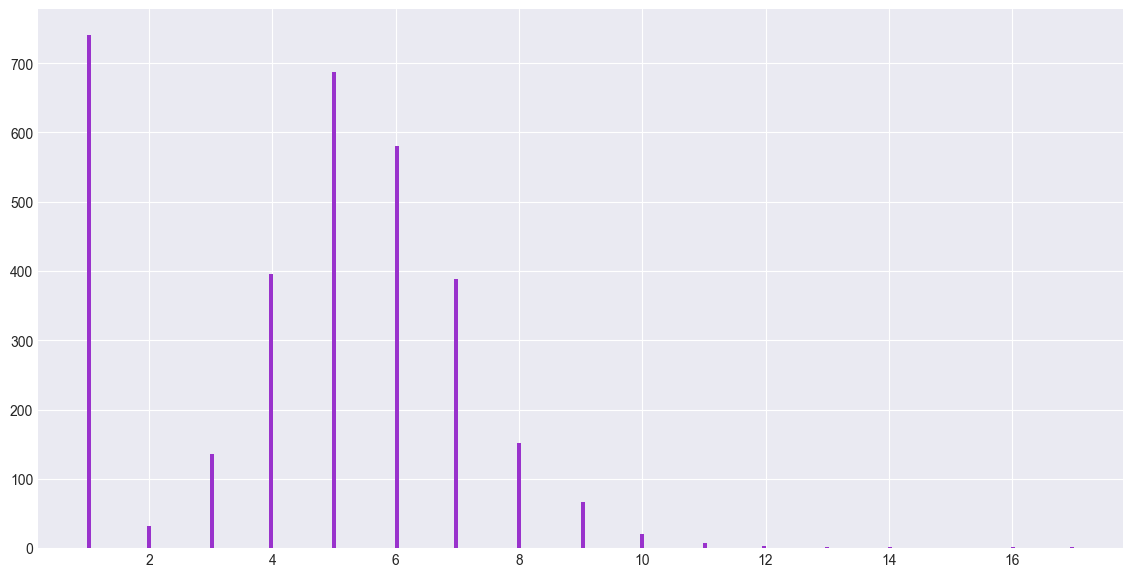

In [26]:
df5.count_temp.hist(figsize=(14, 7), color='darkorchid', bins= 250)
plt.show()

> Те партии где, измерение температуры происходило всего один раз не подходят, а активный рост количества измерений начинается с трех. Оставим только те строки где температура измерялась больше 2 раз так, как основная задача оптимизировать снижение энергопотребления, тогда первые два измерения пойдут в признаки, а последнее измерение в целевой.

<font color='9933ff'><b>
Сохраним партии, где количество измерений больше 2 и зададим новые колонки для первого, второго и последнего измерения
    </b></font>

In [27]:
df5 = df5.loc[df5['count_temp'] > 2]

In [28]:
df5['temperature_first'] = df5['temperature_list'].apply(lambda x: x[0])
df5['temperature_second'] = df5['temperature_list'].apply(lambda x: x[1])
df5['temperature'] = df5['temperature_list'].apply(lambda x: x[-1])
df5

,key,time_by_t_first,time_by_t_last,temperature_list,count_temp,temperature_first,temperature_second,temperature
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,"[1571.0, 1604.0, 1618.0, 1601.0, 1606.0, 1613.0]",6,1571.0,1604.0,1613.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,"[1581.0, 1577.0, 1589.0, 1604.0, 1602.0]",5,1581.0,1577.0,1602.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,"[1596.0, 1597.0, 1598.0, 1599.0, 1600.0, 1599.0]",6,1596.0,1597.0,1599.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,"[1601.0, 1623.0, 1618.0, 1617.0, 1625.0]",5,1601.0,1623.0,1625.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,"[1576.0, 1592.0, 1589.0, 1586.0, 1602.0]",5,1576.0,1592.0,1602.0
...,...,...,...,...,...,...,...,...
2472,2495,2019-08-10 11:27:47,2019-08-10 11:50:47,"[1570.0, 1590.0, 1580.0, 1585.0, 1591.0]",5,1570.0,1590.0,1591.0
2473,2496,2019-08-10 11:56:48,2019-08-10 12:25:13,"[1554.0, 1576.0, 1595.0, 1583.0, 1584.0, 1580....",7,1554.0,1576.0,1591.0
2474,2497,2019-08-10 12:37:26,2019-08-10 12:53:28,"[1571.0, 1577.0, 1576.0, 1589.0]",4,1571.0,1577.0,1589.0
2475,2498,2019-08-10 12:58:11,2019-08-10 13:23:31,"[1591.0, 1570.0, 1580.0, 1593.0, 1582.0, 1594.0]",6,1591.0,1570.0,1594.0


> Результаты измерения температуры перегруппированы и отфильтрованы, также оставлены некоторые колонки для фильтрации при объединении данных.

### Данные о подаче проволочных материалов (объём)

In [29]:
df6.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [30]:
cols = ['Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7' ,'Wire 8', 'Wire 9']
df6['rare_wires'] = df6[cols].sum(axis=1)
df6 = df6.drop(cols, axis=1)

<font color='9933ff'><b>
Пропуски заполними нолями
    </b></font>

In [31]:
df6 = df6.fillna(0)
df6

,key,Wire 1,Wire 2,rare_wires
0,1,60.059998,0.00000,0.0
1,2,96.052315,0.00000,0.0
2,3,91.160157,0.00000,0.0
3,4,89.063515,0.00000,0.0
4,5,89.238236,9.11456,0.0
...,...,...,...,...
3076,3237,38.088959,0.00000,0.0
3077,3238,56.128799,0.00000,0.0
3078,3239,143.357761,0.00000,0.0
3079,3240,34.070400,0.00000,0.0


> Несмотря на то, что 5-й материал был использован всего один раз - он не был удален так, как наблюдения по нему есть и в какой-то из партий была необходимость его использовать. Пропуски заполнены нолями так, как объем добавления материалов равен 0 если его не добавляли. Проволочный материал под номер 1 был использован почти в 100% случаях, а под номером 2 в 30%. Использование других материалов встречается достаточно редко.

## Объединение данных

<font color='9933ff'><b>
Начнем объединять данные с таблицы с целевым признаком. Затем отфильтруем некорректные записи где первый замер температуры был после начала нагрева, а последний перед концом нагрева. Данные о времени подачи дополнительных материалов использоваться не будут в силу своей неинформативности.
    </b></font>

In [32]:
dfs = [df1, df2, df3, df4, df6, df7]
data = df5
for df in dfs:
    data = data.merge(df, on='key', how='inner')

In [33]:
data

,key,time_by_t_first,time_by_t_last,temperature_list,count_temp,temperature_first,temperature_second,temperature,start_heating_tm,end_heating_tm,...,rare_wires,Wire 1_y,Wire 2_y,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,"[1571.0, 1604.0, 1618.0, 1601.0, 1606.0, 1613.0]",6,1571.0,1604.0,1613.0,2019-05-03 11:02:14,2019-05-03 11:28:37,...,0.0,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,"[1581.0, 1577.0, 1589.0, 1604.0, 1602.0]",5,1581.0,1577.0,1602.0,2019-05-03 11:34:14,2019-05-03 11:53:18,...,0.0,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,"[1596.0, 1597.0, 1598.0, 1599.0, 1600.0, 1599.0]",6,1596.0,1597.0,1599.0,2019-05-03 12:06:54,2019-05-03 12:32:19,...,0.0,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,"[1601.0, 1623.0, 1618.0, 1617.0, 1625.0]",5,1601.0,1623.0,1625.0,2019-05-03 12:39:37,2019-05-03 12:57:50,...,0.0,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,"[1576.0, 1592.0, 1589.0, 1586.0, 1602.0]",5,1576.0,1592.0,1602.0,2019-05-03 13:11:13,2019-05-03 13:33:55,...,0.0,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,2495,2019-08-10 11:27:47,2019-08-10 11:50:47,"[1570.0, 1590.0, 1580.0, 1585.0, 1591.0]",5,1570.0,1590.0,1591.0,2019-08-10 11:27:57,2019-08-10 11:48:05,...,0.0,2019-08-10 11:31:40,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2300,2496,2019-08-10 11:56:48,2019-08-10 12:25:13,"[1554.0, 1576.0, 1595.0, 1583.0, 1584.0, 1580....",7,1554.0,1576.0,1591.0,2019-08-10 11:56:58,2019-08-10 12:23:07,...,0.0,2019-08-10 11:59:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2301,2497,2019-08-10 12:37:26,2019-08-10 12:53:28,"[1571.0, 1577.0, 1576.0, 1589.0]",4,1571.0,1577.0,1589.0,2019-08-10 12:37:36,2019-08-10 12:51:20,...,0.0,2019-08-10 12:46:10,2019-08-10 12:40:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2302,2498,2019-08-10 12:58:11,2019-08-10 13:23:31,"[1591.0, 1570.0, 1580.0, 1593.0, 1582.0, 1594.0]",6,1591.0,1570.0,1594.0,2019-08-10 12:58:21,2019-08-10 13:20:59,...,0.0,2019-08-10 13:02:54,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


> В распоряжении остались записи о 2475 партиях с 60 колонками.

## Исследовательский анализ и предобработка данных объединённого датафрейма

<font color='9933ff'><b>
Приведем к нижнему регистру названия колонок и заменим пробелы.
    </b></font>

In [34]:
data.columns = data.columns.str.replace(' ', '_').str.lower()
data['time_of_heating'] = data['time_of_heating'].dt.total_seconds()

In [35]:
data.describe()

,key,count_temp,temperature_first,temperature_second,temperature,active_p,reactive_p,power_ratio,time_of_heating,bulk_3_x,bulk_4_x,bulk_12_x,bulk_14_x,bulk_15_x,rare_bulks,gaz,wire_1_x,wire_2_x,rare_wires
count,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000
mean,1252.240885,5.735677,1586.434028,1587.302951,1593.421441,0.664472,0.489221,3.813933,814.831163,47.652344,37.403646,210.371094,154.999566,121.029948,42.918837,11.425001,102.543538,17.523948,5.193659
std,714.468529,1.568251,28.213333,16.839341,11.197237,0.126884,0.096767,1.266300,335.521741,75.590960,58.786235,156.616352,80.498995,84.243014,89.576550,6.394373,43.454922,33.553982,33.015064
min,1.000000,3.000000,1191.000000,1525.000000,1541.000000,0.307808,0.224525,1.479578,119.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,0.000000,0.000000,0.000000
25%,631.750000,5.000000,1571.000000,1577.000000,1587.000000,0.577172,0.420898,3.165690,587.750000,0.000000,0.000000,105.000000,106.000000,0.000000,0.000000,7.339834,73.885499,0.000000,0.000000
50%,1254.500000,6.000000,1586.000000,1587.000000,1593.000000,0.656895,0.484845,3.940841,782.000000,0.000000,0.000000,206.000000,149.000000,108.000000,0.000000,10.141563,101.119202,0.000000,0.000000
75%,1867.250000,7.000000,1603.000000,1597.000000,1598.000000,0.741409,0.546467,4.761225,996.000000,80.250000,78.000000,290.000000,204.000000,204.000000,63.000000,14.223578,128.097058,23.102560,0.000000
max,2499.000000,17.000000,1660.000000,1662.000000,1653.000000,1.243889,0.960763,13.058278,4189.000000,454.000000,281.000000,1849.000000,636.000000,405.000000,1187.000000,77.995040,330.314424,282.780152,385.008668


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 48 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 2304 non-null   int64  
 1   time_by_t_first     2304 non-null   object 
 2   time_by_t_last      2304 non-null   object 
 3   temperature_list    2304 non-null   object 
 4   count_temp          2304 non-null   int64  
 5   temperature_first   2304 non-null   float64
 6   temperature_second  2304 non-null   float64
 7   temperature         2304 non-null   float64
 8   start_heating_tm    2304 non-null   object 
 9   end_heating_tm      2304 non-null   object 
 10  active_p            2304 non-null   float64
 11  reactive_p          2304 non-null   float64
 12  power_ratio         2304 non-null   float64
 13  time_of_heating     2304 non-null   float64
 14  bulk_3_x            2304 non-null   float64
 15  bulk_4_x            2304 non-null   float64
 16  bulk_1

<font color='9933ff'><b>
Заполним пропуски нолями, затем удалим колонки с датами, количеством измерений, временную колонку, номера партий, активные и реактивные мощности и лист результатов измерений температур
    </b></font>

In [37]:
data = data.fillna(0)
cols_to_keep=["temperature_first", "temperature", "power_ratio", "time_of_heating", "bulk_3_x",\
      "bulk_4_x", "bulk_12_x", "bulk_14_x", "bulk_15_x", "rare_bulks", "gaz", "wire_1_x", "wire_2_x", "rare_wires"]
data = data[cols_to_keep]

> Колонка с проволочным материалом 5, где была доступна всего одна запись - удалена.

In [38]:
data

,temperature_first,temperature,power_ratio,time_of_heating,bulk_3_x,bulk_4_x,bulk_12_x,bulk_14_x,bulk_15_x,rare_bulks,gaz,wire_1_x,wire_2_x,rare_wires
0,1571.0,1613.0,4.083428,1098.0,0.0,43.0,206.0,150.0,154.0,0.0,29.749986,60.059998,0.00000,0.0
1,1581.0,1602.0,3.301105,811.0,0.0,73.0,206.0,149.0,154.0,0.0,12.555561,96.052315,0.00000,0.0
2,1596.0,1599.0,4.048621,655.0,0.0,34.0,205.0,152.0,153.0,0.0,28.554793,91.160157,0.00000,0.0
3,1601.0,1625.0,3.175691,741.0,0.0,81.0,207.0,153.0,154.0,0.0,18.841219,89.063515,0.00000,0.0
4,1576.0,1602.0,3.187274,869.0,0.0,78.0,203.0,151.0,152.0,0.0,5.413692,89.238236,9.11456,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,1570.0,1591.0,3.250906,723.0,21.0,0.0,256.0,129.0,223.0,90.0,7.125735,89.150879,0.00000,0.0
2300,1554.0,1591.0,4.917636,940.0,0.0,63.0,256.0,129.0,226.0,122.0,9.412616,114.179527,0.00000,0.0
2301,1571.0,1589.0,2.482839,569.0,0.0,85.0,230.0,124.0,226.0,0.0,6.271699,94.086723,9.04800,0.0
2302,1591.0,1594.0,4.096223,750.0,90.0,0.0,206.0,129.0,207.0,101.0,14.953657,118.110717,0.00000,0.0


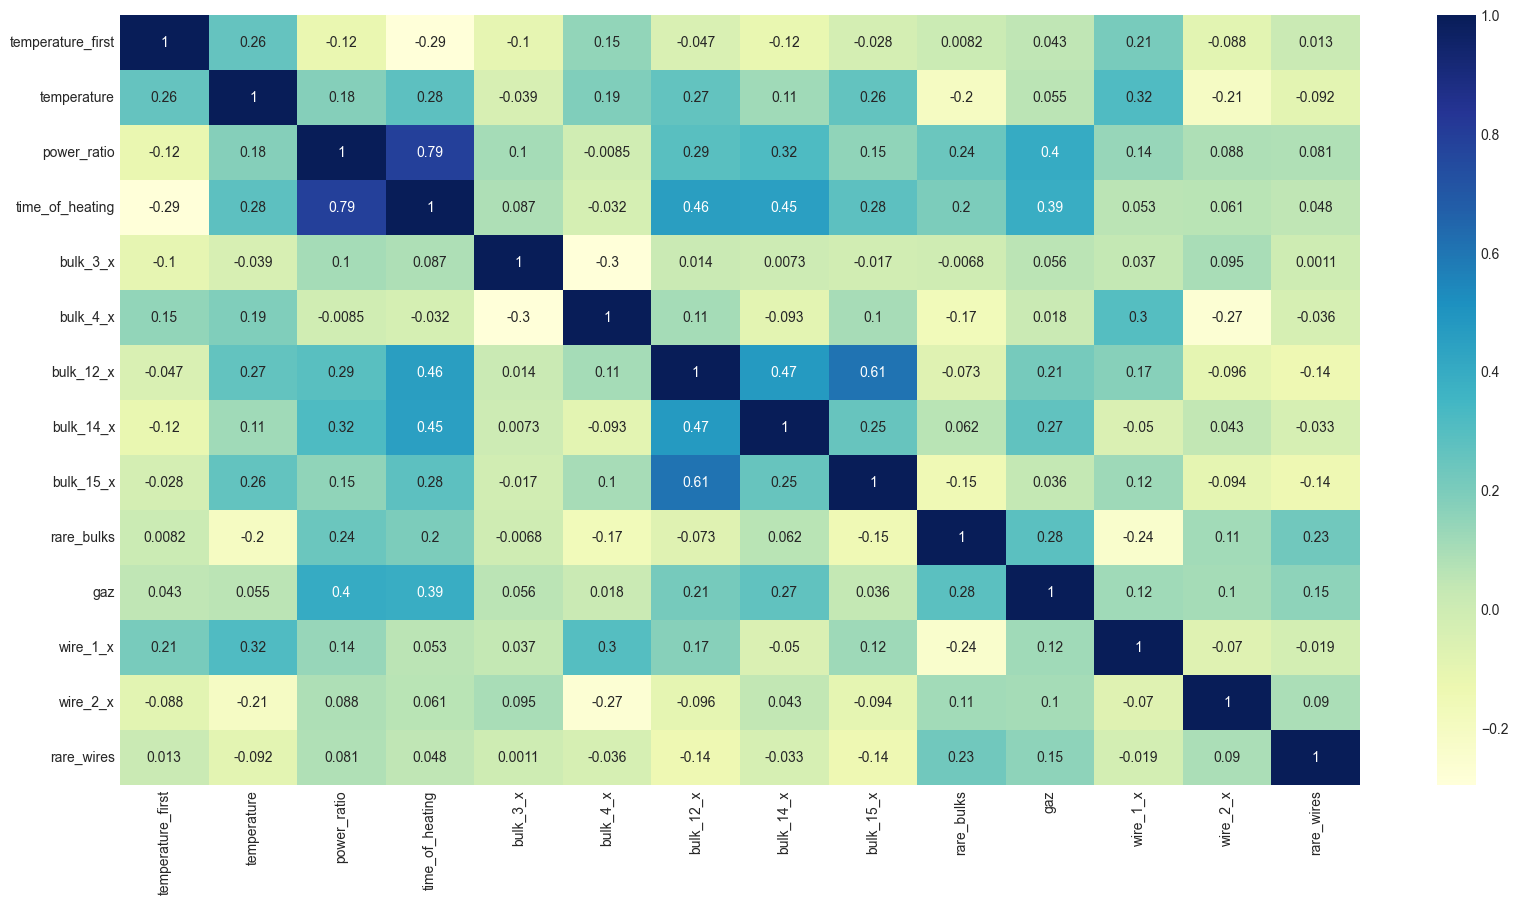

In [39]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr(), annot=True, cmap='YlGnBu')
plt.show()

> Сильно выделяется положительная линейная взаимосвязь между bulk_9 и wire_8, также достаточно высокая положительная корреляция между bulk_7 и wire_4, bulk_2 и wire_4, bulk_7 и bulk_2, wire_7 и wire_4. Можно предположить, что высокая корреляции между признаками(дополнительными материалами) вызвана техническим процессом обработки стали.

## Подготовка данных

<font color='9933ff'><b>
Разобьем данные на 2 выборки, затем инициализируем скорер для гридсерча
    </b></font>

In [40]:
SEED = 281223

In [41]:
xTrain, xTest, yTrain, yTest = train_test_split(data.drop('temperature' , axis=1),\
                                                data.temperature, test_size = 0.25 , random_state = SEED)

In [42]:
loss_fn = make_scorer(mean_absolute_error, greater_is_better=False)

## Обучение моделей

<font color='9933ff'><b>
Далее перебор гиперпараметров для нескольких моделей методом гридсерч
    </b></font>

### CatBoost

In [43]:
hyperparameters1 = {'verbose' : [0],
                   'iterations': [100, 800],
                   'learning_rate': [0.03, 0.01],
                   'boosting_type': ['Plain', 'Ordered'],
                   'depth': [4, 6]}
cbr = GridSearchCV(CatBoostRegressor(), hyperparameters1, n_jobs=-1, scoring=loss_fn)
cbr.fit(xTrain, yTrain)
best_cbr = cbr.best_estimator_

### LightGBM

In [44]:
hyperparameters2 = {'boosting_type': ['gbdt','rf'],
                   'learning_rate': [0.01, 0.0001],
                   'num_leaves' : [31, 62],
                   'reg_lambda':[0.1,0.3]}
lgbmr = GridSearchCV(LGBMRegressor(), hyperparameters2, n_jobs=-1, scoring=loss_fn)
lgbmr.fit(xTrain, yTrain)
best_lgbmr = lgbmr.best_estimator_

C:\Users\warri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\warri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\warri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-pack

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2238
[LightGBM] [Info] Number of data points in the train set: 1728, number of used features: 13
[LightGBM] [Info] Start training from score 1593.246528


### RidgeCV

In [45]:
hyperparameters3 = {'fit_intercept': [True, False],
                   'gcv_mode': ['svd', 'eigen']}
ridge = GridSearchCV(RidgeCV(), hyperparameters3, n_jobs=-1, scoring=loss_fn)
ridge.fit(xTrain, yTrain)
best_ridge = ridge.best_estimator_

### RandomForest

In [46]:
hyperparameters4 = {'n_estimators' : [600, 800],
                    'max_depth': [6, 12],
                    'min_samples_leaf':[3, 6]}
rfc = GridSearchCV(RandomForestRegressor(), hyperparameters4, n_jobs=-1, scoring=loss_fn)
rfc.fit(xTrain, yTrain)
best_rfc = rfc.best_estimator_

## Выбор лучшей модели

<font color='9933ff'><b>
Выведем результаты моделей на обучающей выборке в виде информативной таблицы
    </b></font>

In [47]:
models = {"CatBoostR": cbr.best_score_,
          "LightGBMR": lgbmr.best_score_,
          "RidgeCV": ridge.best_score_,
          "RandomForest": rfc.best_score_}
models = pd.DataFrame(list(models.items()), columns=['Model', 'Best Score'])
models

,Model,Best Score
0,CatBoostR,-6.228874
1,LightGBMR,-6.868734
2,RidgeCV,-6.725162
3,RandomForest,-6.410437


> Лучший результат у модели CatBoost.

<font color='9933ff'><b>
Проверим результат модели и сравним с константной на тестовой выборке, затем посмотрим на важность признаков
    </b></font>

In [48]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(xTrain, yTrain)

preds_d = dummy.predict(xTest)
mae1 = mean_absolute_error(preds_d,yTest)
pred = best_cbr.predict(xTest)
mae2 = mean_absolute_error(pred,yTest)


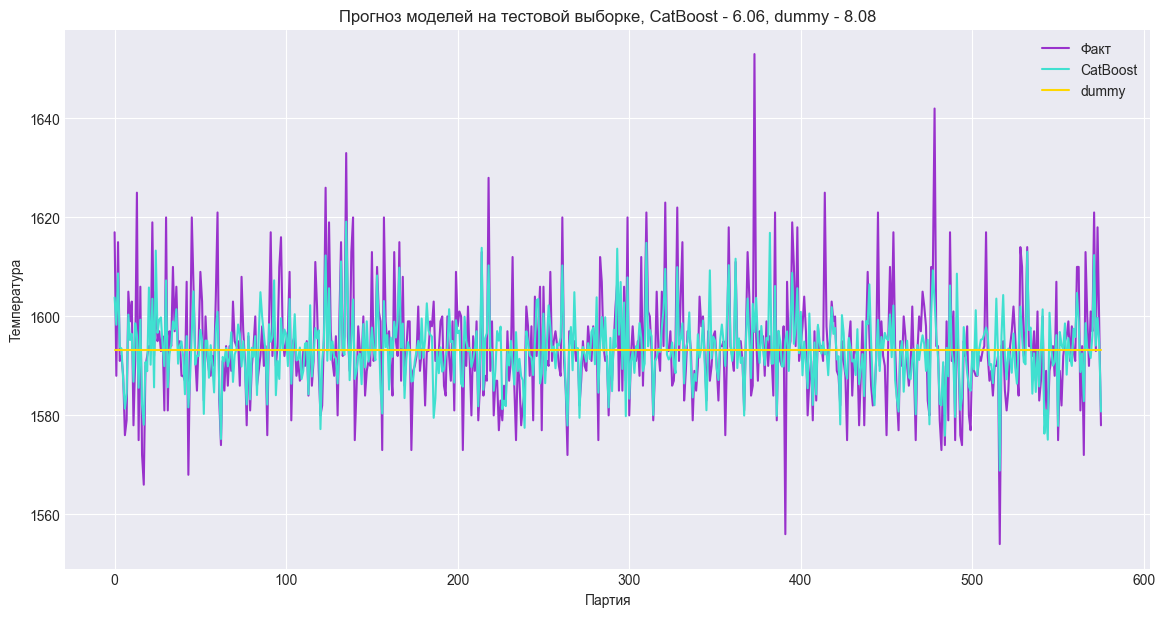

In [49]:
plt.figure(figsize=(14, 7))
plt.plot(yTest.reset_index(drop=True),label='Факт', color='darkorchid')
plt.plot(pd.Series(pred),label='CatBoost', color='turquoise')
plt.plot(pd.Series(preds_d),label='dummy', color='gold')
plt.legend()
plt.title(f'Прогноз моделей на тестовой выборке, CatBoost - {mae2:.2f}, dummy - {mae1:.2f}')
plt.xlabel('Партия')
plt.ylabel('Температура')
plt.show()

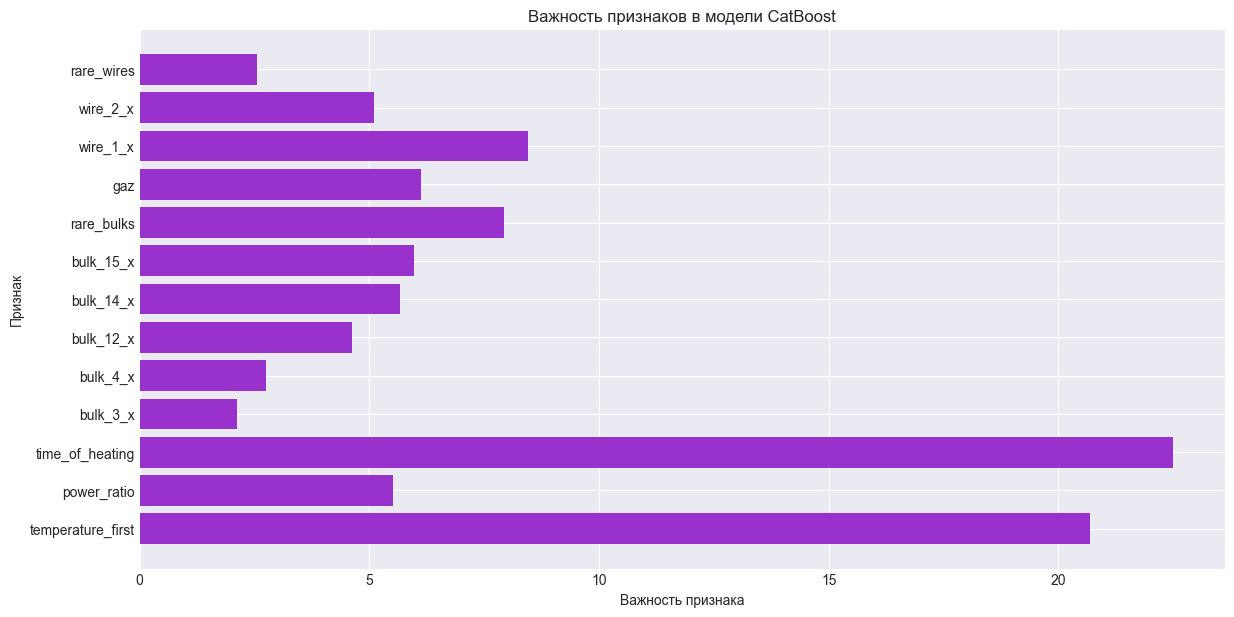

In [50]:
feature_importances = best_cbr.feature_importances_
feature_names = xTrain.columns
plt.figure(figsize=(14, 7))
plt.barh(range(len(feature_importances)), feature_importances, tick_label=feature_names, color='darkorchid')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в модели CatBoost')
plt.show()

>На тестовой выборке модель оказалась точна на 6.06, константная на 8.08. Помимо высокой важности первого измерения температуры, модель считает, что существенное влияние на итоговую температуру оказывает время нагрева, а также материал под индексом wire_1 и сыпучие материалы, которые используются редко.

## Итог

<font color='9933ff'><b>
Общий вывод
    </b></font>

Целью работы являлась оптимизация производственных расходов, стояла задача прогнозирования финальной температуры стали в ковше. В качестве исходных данных были использованые наблюдения с записями об электродах, подаче и времени сыпучих и проволочных материалах, продувке газом, результаты измерений температур в разные стадии производства.

В ходе предварительной обработки от исходных 3241 партий удалось выделить 2304 объекта.

При иследовательском анализе удалось прийти к следующим выводам:
+ Распределение температуры лежит около 1590 градусов; коэффициента мощности 0.81; подачи газа 9
+ Сильно выделяется положительная линейная взаимосвязь между bulk_9 и wire_8, также достаточно высокая положительная корреляция между bulk_7 и wire_4, bulk_2 и wire_4, bulk_7 и bulk_2, wire_7 и wire_4. Можно предположить, что высокая корреляции между признаками(дополнительными материалами) вызвана техническим процессом обработки стали.

В ходе обучения приемлемый результат оказался у всех моделей.

В качестве лучшей модели была выбрана CatBoost с мае на тесте - 6.06

<font color='9933ff'><b>
Рекомендации заказчику
    </b></font>

В целях улучшения результатов прогнозирования моделей можно применить алгоритм автоматической генерации признаков, на основе имеющихся или подобрать более подходящие гиперпараметры для моделей. А также стоит обратить внимание на проволочный материал wire_1 так, как в сравнении с другими материалами он оказывает существенное влияние на температуру.